# PaleoAI Dataset Arithmetic

`paleoai_dataset_arithmetic.ipynb`

This notebook is for using pandas dataframes for elegantly adding or subtracting sets of data samples while maintaining unique-specimen constraints based on enforcing uniqueness for a user-specified id column. Using simple operator overloading in Python class definitions, we can perform complex queries with minimal boilerplate.

Author: Jacob A Rose  
Created on: Monday July 19th, 2021

## Top

In [ ]:
# module;function;builtin_function_or_method;ABCMeta;type

In [ ]:
%load_ext autoreload
%autoreload 2

# Code that has been outsourced to scripts

In [ ]:
from lightning_hydra_classifiers.data.common import CommonDataset, PathSchema
from lightning_hydra_classifiers.utils.dataset_management_utils import Extract
from lightning_hydra_classifiers.utils.common_utils import LabelEncoder

from IPython.display import display

import torchdata
from pathlib import Path
from copy import deepcopy
import os
import shutil
import pandas as pd
# a = torchdata.datasets.Files(["class_0/image_0.jpg"])

CommonDataset.available_datasets

from dataclasses import dataclass
from typing import *
from omegaconf import DictConfig
import collections


        
@dataclass
class BaseDatasetConfig:

    def save(self,
             path: Union[str, Path]) -> None:
#         keys = self.__dataclass_fields__.keys()
        cfg = DictConfig({k: getattr(self,k) for k in self.keys()})
        Extract.config2yaml(cfg, path)
    
    @classmethod
    def load(cls,
             path: Union[str, Path]) -> "DatasetConfig":

        cfg = Extract.config_from_yaml(path)

#         keys = cls.__dataclass_fields__.keys()
        cfg = cls(**{k: cfg[k] for k in cls.keys()})
        return cfg
    
    @classmethod
    def keys(cls):
        return cls.__dataclass_fields__.keys()
    
    def __repr__(self):
        out = f"{type(self)}" + "\n"
        out += "\n".join([f"{k}: {getattr(self, k)}" for k in self.keys()])
#         out += f"\nroot_dir: {self.root_dir}"
#         out += "\nsubset_dirs: \n\t" + '\n\t'.join(self.subset_dirs)
        return out
    
@dataclass
class DatasetConfig(BaseDatasetConfig):
    base_dataset_name: str = "Extant"
    class_type: str = "family"
    threshold: int = 10
    resolution: int = 512
    path_schema: str = "{family}_{genus}_{species}_{collection}_{catalog_number}"

    @property
    def full_name(self):
        return f"{self.base_dataset_name}_{self.class_type}_{self.threshold}_{self.resolution}"
    
from functools import cached_property #lru_cache


    
class ImageFileDatasetConfig(DatasetConfig):
    
    @property
    def root_dir(self):
        return CommonDataset.available_datasets[self.full_name]
    
    def is_valid_subset(self, subset: str):
        for s in ("train", "val", "test"):
            if s in subset:
                return True
        return False
    
    @property
    def subsets(self):
        return [s for s in os.listdir(self.root_dir) if  self.is_valid_subset(s)]
    
    @property
    def subset_dirs(self):
        return [os.path.join(self.root_dir, subset) for subset in self.subsets]
#         subsets = self.subsets
#         return [os.path.join(self.root_dir, subset) for subset in subsets if self.is_valid_subset(subset)]

    def locate_files(self) -> Dict[str, List[Path]]:
        return Extract.locate_files(self.root_dir)


    @cached_property
    def num_samples(self):
#         subset_dirs = {Path(subset_dir).stem: Path(subset_dir) for subset_dir in self.subset_dirs}
        files = {subset: f for subset, f in self.locate_files().items() if self.is_valid_subset(subset)}
        return {subset: len(list(f)) for subset, f in files.items()}
#         return {subset: len(list(subset_dirs[subset].rglob("*/*.jpg"))) for subset in subset_dirs.keys()}
    
    
    def __repr__(self):
        out = super().__repr__()
        out += f"\nroot_dir: {self.root_dir}"
        out += "\nsubsets: "
        for i, subset in enumerate(self.subsets):
            out += '\n\t' + f"{subset}:"
            out += '\n\t\t' + f"subdir: {self.subset_dirs[i]}"
            out += '\n\t\t' + f"subset_num_samples: {self.num_samples[subset]}"
#         out += '\n\t'.join(self.subset_dirs)
#         out += "\nsubset_dirs: \n\t" + '\n\t'.join(self.subset_dirs)
        return out


@dataclass
class CSVDatasetConfig(BaseDatasetConfig):
    
    full_name: str = None
    csv_path: str = None
    subset_key: str = "all"

    def locate_files(self) -> pd.DataFrame: #Dict[str, List[Path]]:
        return Extract.df_from_csv(self.csv_path)

    @cached_property
    def num_samples(self):
        return {self.subset_key: len(self.locate_files())}

    def __repr__(self):
        out = super().__repr__()
        out += '\n' + f"num_samples: {self.num_samples['all']}"
#         out += '\n\t'.join(self.subset_dirs)
#         out += "\nsubset_dirs: \n\t" + '\n\t'.join(self.subset_dirs)
        return out


########################################


@dataclass
class SampleSchema:
    path : Union[str, Path] = None
    family : str = None
    genus : str = None
    species : str = None
    collection : str = None
    catalog_number : str = None

    @classmethod
    def keys(cls):
        return list(cls.__dataclass_fields__.keys())
        
    def __getitem__(self, index: int):
        return getattr(self, self.keys()[index])
        
totensor: Callable = torchvision.transforms.ToTensor()
toPIL: Callable = torchvision.transforms.ToPILImage("RGB")
    
    
    
# class CommonDataArithmetic(torchdata.datasets.Files): # (CommonDataset):
class CustomDataset(torchdata.datasets.Files): # (CommonDataset):

    def __init__(self,
                 files: List[Path]=None,
                 samples_df: pd.DataFrame=None,
                 path_schema: Path = "{family}_{genus}_{species}_{collection}_{catalog_number}",
                 return_signature: List[str] = ["image","target","path"],
                 config: Optional[BaseDatasetConfig]=None):
        files = files or []
        super().__init__(files=files)
#         self.samples_df = samples_df
        self.path_schema = PathSchema(path_schema)
        self.return_signature = collections.namedtuple("return_signature", return_signature)
        
        self.x_col = "path"
        self.y_col = "family"
        self.id_col = "catalog_number"
        self.config = config or {}
        
        self.setup(samples_df=samples_df)
        
        
    def fetch_item(self, index: int) -> Tuple[str]:
        sample = self.parse_sample(index)
        image = Image.open(sample.path)
        return self.return_signature(image=image,
                                     target=getattr(sample, self.y_col),
                                     path=getattr(sample, self.x_col))

    def __getitem__(self, index: int):
        
        item = self.parse_sample(index)
        image, target, path = item.image, item.target, str(item.path)
        target = self.label_encoder.class2idx[target]
        
#         if self.transform is not None:
#             image = self.transform(image)
#         if self.target_transform is not None:
#             target = self.target_transform(target)


        image = totensor(image)
            
        return tuple(self.return_signature(image=image, target=target, path=path))
    
        
    def setup(self,
              samples_df: pd.DataFrame=None,
              label_encoder: LabelEncoder=None,
              fit_targets: bool=True):
        if samples_df is not None:
            self.samples_df = samples_df.convert_dtypes()
        self.samples = [self.parse_sample(idx) for idx in range((len(self)))]
        self.targets = [sample[1] for sample in self.samples]
        self.samples_df = pd.DataFrame(self.samples).convert_dtypes()
        
        self.label_encoder = label_encoder or LabelEncoder()
        if fit_targets:
            self.label_encoder.fit(self.targets)
        
    @classmethod
    def from_config(cls, config: DatasetConfig, subset_keys: List[str]=None) -> "CustomDataset":
        pass
        
    def parse_sample(self, index: int):
        pass
    
    def __repr__(self):
        disp = f"""<{str(type(self)).strip("'>").split('.')[1]}>:"""
        disp += '\n\t' + self.config.__repr__().replace('\n','\n\t')
        return disp

    
    @classmethod
    def get_files_from_samples(cls,
                               samples: Union[pd.DataFrame, List],
                               x_col: Optional[str]="path"):
        if isinstance(samples, pd.DataFrame):
            if x_col in samples.columns:
                files = list(samples[x_col].values)
            else:
                files = list(samples.iloc[:,0].values)
        elif isinstance(samples, list):
            files = [s[0] for s in self.samples]
            
        return files
    
    def intersection(self, other):
        samples_df = self.samples_df
        other_df = other.samples_df
        
        intersection = samples_df.merge(other_df, how='inner', on=self.id_col)
        return intersection
    
    def __add__(self, other):
    
        intersection = self.intersection(other)[self.id_col].tolist()
        samples_df = self.samples_df
        
        left_union = samples_df[samples_df[self.id_col].apply(lambda x: x in intersection)]
        
        return left_union
    
    def __sub__(self, other):
    
        intersection = self.intersection(other)[self.id_col].tolist()
        samples_df = self.samples_df
        
        remainder = samples_df[samples_df[self.id_col].apply(lambda x: x not in intersection)]
        
        return remainder
    
    
    
    
class ImageFileDataset(CustomDataset):
    
    @classmethod
    def from_config(cls, config: DatasetConfig, subset_keys: List[str]=None) -> "CustomDataset":
        files = config.locate_files()
        if isinstance(subset_keys, list):
            files = {k: files[k] for k in subset_keys}
        if len(files.keys())==1: 
            files = files[subset_keys[0]]
        new = cls(files=files,
                  path_schema=config.path_schema)
        new.config = config
        return new
    
    def parse_sample(self, index: int):
        path = self.files[index]
        family, genus, species, collection, catalog_number = self.path_schema.parse(path)

        return SampleSchema(path=path,
                             family=family,
                             genus=genus,
                             species=species,
                             collection=collection,
                             catalog_number=catalog_number)


class CSVDataset(CustomDataset):
    
    @classmethod
    def from_config(cls, config: DatasetConfig, subset_keys: List[str]=None) -> Union[Dict[str, "CSVDataset"], "CSVDataset"]:
        files_df = config.locate_files()
        if subset_keys is None:
            subset_keys = ['all']
        if isinstance(subset_keys, list) and isinstance(files_df, dict):
            files_df = {k: files_df[k] for k in subset_keys}
            new = {k: cls(samples_df=files_df[k]) for k in subset_keys}
            for k in subset_keys:
                new.config = deepcopy(config)
                new.config.subset_key = k
#         if len(files_df.keys())==1: 
        if len(subset_keys)==1:
            if isinstance(files_df, dict):
                files_df = files_df[subset_keys[0]]
            new = cls(samples_df=files_df)
            new.config = config
            new.config.subset_key = subset_keys[0]
        return new
    
    def setup(self,
              samples_df: pd.DataFrame=None,
              label_encoder: LabelEncoder=None,
              fit_targets: bool=True):
        
        if samples_df is not None:
            self.samples_df = samples_df.convert_dtypes()
        

        self.files = self.samples_df[self.x_col].apply(lambda x: Path(x)).tolist()
        self.samples = [self.parse_sample(idx) for idx in range((len(self)))]
        self.targets = [sample[1] for sample in self.samples]       
        self.samples_df = pd.DataFrame(self.samples).convert_dtypes()
        
        self.label_encoder = label_encoder or LabelEncoder()
        if fit_targets:
            self.label_encoder.fit(self.targets)
        
    
    def parse_sample(self, index: int):
        
        row = self.samples_df.iloc[index,:].tolist()
        path, family, genus, species, collection, catalog_number = row
        return SampleSchema(path=path,
                             family=family,
                             genus=genus,
                             species=species,
                             collection=collection,
                             catalog_number=catalog_number)
    
    



def export_dataset_catalog_configuration(output_dir: str = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3",
                                         base_dataset_name = "Extant",
                                         threshold = 100,
                                         resolution = 512,
                                         path_schema: str = "{family}_{genus}_{species}_{collection}_{catalog_number}"):
    
    image_file_config = ImageFileDatasetConfig(base_dataset_name = base_dataset_name,
                                               class_type = "family",
                                               threshold = threshold,
                                               resolution = resolution,
                                               path_schema = path_schema)

    out_dir = os.path.join(output_dir, image_file_config.full_name)
    os.makedirs(out_dir, exist_ok=True)

    csv_out_path = os.path.join(out_dir, f"{image_file_config.full_name}-full_dataset.csv")
    image_file_config_out_path = os.path.join(out_dir,"ImageFileDataset-config.yaml")
    csv_config_out_path = os.path.join(out_dir,"CSVDataset-config.yaml")

    dataset = ImageFileDataset.from_config(image_file_config, subset_keys=['all'])
    Extract.df2csv(dataset.samples_df,
                   path = csv_out_path)
    image_file_config.save(image_file_config_out_path)

    csv_config = CSVDatasetConfig(full_name = image_file_config.full_name,
                                  csv_path = csv_out_path,
                                  subset_key = "all")

    csv_config.save(csv_config_out_path)

    print(f"[FINISHED] DATASET FULL NAME: {csv_config.full_name}")
    print(f"Newly created dataset assets located at:  {out_dir}")
    
    return dataset, image_file_config, csv_config

################################################

def export_composite_dataset_catalog_configuration(output_dir: str = ".",
                                                   csv_cfg_path_A: str=None,
                                                   csv_cfg_path_B: str=None,
                                                   composition: str="-") -> Tuple[CSVDataset, CSVDatasetConfig]:
    
    
    csv_config_A = CSVDatasetConfig.load(path = csv_cfg_path_A)
    csv_config_B = CSVDatasetConfig.load(path = csv_cfg_path_B)

    dataset_A = CSVDataset.from_config(csv_config_A)
    dataset_B = CSVDataset.from_config(csv_config_B)

    if composition == '-':
        dataset_A_minus_B = dataset_B - dataset_A
        full_name = f"{csv_config_A.full_name}_minus_{csv_config_B.full_name}"
        
    out_dir = os.path.join(output_dir, full_name)
    os.makedirs(out_dir, exist_ok=True)

    inputs_dir = os.path.join(out_dir, "inputs")
    os.makedirs(inputs_dir, exist_ok=True)
    os.makedirs(os.path.join(inputs_dir, "A"), exist_ok=True)
    os.makedirs(os.path.join(inputs_dir, "B"), exist_ok=True)
    shutil.copyfile(csv_cfg_path_A, os.path.join(inputs_dir, "A", Path(csv_cfg_path_A).name))
    shutil.copyfile(csv_cfg_path_B, os.path.join(inputs_dir, "B", Path(csv_cfg_path_B).name))

    csv_dataset_pathname = f"{full_name}-full_dataset"
    csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
    csv_dataset_config_out_path = os.path.join(out_dir,f"{csv_dataset_pathname}_CSVDataset-config.yaml")    

    Extract.df2csv(dataset_A_minus_B,
                   path = csv_dataset_out_path)

    A_minus_B_config = CSVDatasetConfig(full_name = full_name,
                                        csv_path = csv_dataset_out_path,
                                        subset_key = "all")
    A_minus_B_config.save(csv_dataset_config_out_path)

    print(f"[FINISHED] DATASET: {full_name}")
    print(f"Newly created dataset assets located at:  {out_dir}")
    
    dataset_A_minus_B = CSVDataset.from_config(csv_config_B)
    return dataset_A_minus_B, A_minus_B_config

    

In [ ]:
%%bash

cd "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"

rm -r "Extant_family_100_512_minus_PNAS_family_100_512"
rm -r "Extant_family_10_1024_minus_PNAS_family_100_1024"
rm -r "Extant_family_10_512_minus_PNAS_family_100_512"
rm -r "Extant_family_100_1024_minus_PNAS_family_100_1024"

cd "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"


rm -r "Extant_family_100_512_w_PNAS_family_100_512"
rm -r "Extant_family_10_1024_w_PNAS_family_100_1024"
rm -r "Extant_family_10_512_w_PNAS_family_100_512"
rm -r "Extant_family_100_1024_w_PNAS_family_100_1024"

In [ ]:
# %%bash

# cd "/media/data/jacob/GitHub/lightning-hydra-classifiers/lightning_hydra_classifiers/data/utils"
# python "make_catalogs.py --extant-pnas"

# output_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"

# base_names = {"A": "Extant",
#               "B": "PNAS"}
# thresholds = [{"A":100,
#                "B":100},
#              {"A":10,
#                "B":100}]
# resolutions = [512, 1024]
# class_type = "family"


# for threshold in thresholds:
#     for resolution in resolutions:
#         dataset_full_names = {"A":"_".join([base_names["A"], class_type, str(threshold["A"]), str(resolution)]),
#                               "B":"_".join([base_names["B"], class_type, str(threshold["B"]), str(resolution)])}

#         csv_cfg_path_A = os.path.join(output_dir, dataset_full_names["A"], "CSVDataset-config.yaml")
#         csv_cfg_path_B = os.path.join(output_dir, dataset_full_names["B"], "CSVDataset-config.yaml")
        
#         break
        
        
# print("A:", csv_cfg_path_A,
#       "B:", csv_cfg_path_B)

In [ ]:
from lightning_hydra_classifiers.data.utils import make_catalogs
dir(make_catalogs)

from lightning_hydra_classifiers.data.utils.make_catalogs import *

# A_minus_B_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_100_512_minus_PNAS_family_100_512")
A_minus_B_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512")

config_path = list(A_minus_B_dir.glob("./*CSVDataset-config.yaml"))[0]
dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
config = CSVDatasetConfig.load(path = config_path)
dataset = CSVDataset.from_config(config)

print(config)
print(dataset)



In [ ]:
# composition = '-'

# csv_config_A = CSVDatasetConfig.load(path = csv_cfg_path_A)
# csv_config_B = CSVDatasetConfig.load(path = csv_cfg_path_B)

# dataset_A = CSVDataset.from_config(csv_config_A)
# dataset_B = CSVDataset.from_config(csv_config_B)

# if composition == '-':
#     dataset_A_minus_B = dataset_B - dataset_A
#     full_name = f"{csv_config_A.full_name}_minus_{csv_config_B.full_name}"

# print(f"num_samples A: {len(dataset_A)}")
# print(f"num_samples B: {len(dataset_B)}")
# print(f"num_samples A-B: {len(dataset_A_minus_B)}")        

In [ ]:
config_path = list(A_minus_B_dir.glob("./inputs/A/*CSVDataset-config.yaml"))[0]
# dataset_path = list(A_minus_B_dir.glob("./inputs/A/*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)

config_A = CSVDatasetConfig.load(path = config_path)
dataset_A = CSVDataset.from_config(config_A)

print(dataset_A.__repr__())

In [ ]:
config_path = list(A_minus_B_dir.glob("./inputs/B/*CSVDataset-config.yaml"))[0]
# dataset_path = list(A_minus_B_dir.glob("./inputs/A/*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)

config_B = CSVDatasetConfig.load(path = config_path)
dataset_B = CSVDataset.from_config(config_B)

print(dataset_B.__repr__())

In [ ]:
%%time

output_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"


base_dataset_name = "Extant"
thresholds = [10,100]
resolutions = [512,1024]
path_schema = "{family}_{genus}_{species}_{collection}_{catalog_number}"

for threshold in thresholds:
    for resolution in resolutions:
        export_dataset_catalog_configuration(output_dir=output_dir,
                                             base_dataset_name = base_dataset_name,
                                             threshold = threshold,
                                             resolution = resolution,
                                             path_schema = path_schema)

print(f'FINISHED ALL IN Extant')
print('=='*15)

base_dataset_name = "PNAS"
thresholds = [100]
resolutions = [512,1024]
path_schema = "{family}_{genus}_{species}_{catalog_number}"
for threshold in thresholds:
    for resolution in resolutions:
        export_dataset_catalog_configuration(output_dir=output_dir,
                                             base_dataset_name = base_dataset_name,
                                             threshold = threshold,
                                             resolution = resolution,
                                             path_schema = path_schema)

print(f'FINISHED ALL IN PNAS')
print('=='*15)


output_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"

base_names = {"A": "Extant",
              "B": "PNAS"}
thresholds = [{"A":100,
               "B":100},
             {"A":10,
               "B":100}]
resolutions = [512, 1024]

class_type = "family"


for threshold in thresholds:
    for resolution in resolutions:
        dataset_full_names = {"A":"_".join([base_names["A"], class_type, str(threshold["A"]), str(resolution)]),
                              "B":"_".join([base_names["B"], class_type, str(threshold["B"]), str(resolution)])}

        csv_cfg_path_A = os.path.join(output_dir, dataset_full_names["A"], "CSVDataset-config.yaml")
        csv_cfg_path_B = os.path.join(output_dir, dataset_full_names["B"], "CSVDataset-config.yaml")
        dataset, cfg = export_composite_dataset_catalog_configuration(output_dir=output_dir,
                                                                      csv_cfg_path_A=csv_cfg_path_A,
                                                                      csv_cfg_path_B=csv_cfg_path_B,
                                                                      composition="-")
        
        
print(f'FINISHED ALL IN Extant-PNAS')
print('=='*15)

# Back to R & D

In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from lightning_hydra_classifiers.data.utils.catalog_registry import *
from lightning_hydra_classifiers.data.utils.make_catalogs import *

catalog = available_datasets()


output_dir: str = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v1_0"
image_file_config = ImageFileDatasetConfig(base_dataset_name = "Fossil",
                                           class_type = "family",
                                           threshold = None,
                                           resolution = 512,
                                           version="v1_0")
dataset = ImageFileDataset.from_config(image_file_config, subset_keys=['all'])
dataset

<data>:
	ImageFileDatasetConfig(base_dataset_name='Fossil', class_type='family', threshold=None, resolution=512, version='v1_0', path_schema='{family}_{genus}_{species}_{collection}_{catalog_number}')
	root_dir: ['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/512/full/jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg']
	subsets: 
	num_samples: 4077

In [2]:
# image_file_config = ImageFileDatasetConfig(base_dataset_name = "Florissant_Fossil",
#                                            class_type = "family",
#                                            threshold = None,
#                                            resolution = 512,
#                                            version="v1_0")
# dataset = ImageFileDataset.from_config(image_file_config, subset_keys=['all'])
# dataset

<data>:
	ImageFileDatasetConfig(base_dataset_name='Florissant_Fossil', class_type='family', threshold=None, resolution=512, version='v1_0', path_schema='{family}_{genus}_{species}_{collection}_{catalog_number}')
	root_dir: /media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg
	subsets: 
	num_samples: 3320

In [32]:
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
import numpy as np
import PIL
# img = np.array(dataset[0][0])

from skimage import filters
from skimage.color import rgb2gray

def plot_edge_detections_sobel(img: PIL.Image.Image):
    grayscale = rgb2gray(np.array(img))
    ed_sobel = filters.sobel(grayscale)

    fig, ax = plt.subplots(1,3, figsize=(10*3,10), sharey=True)
    ax[0].imshow(grayscale, cmap="gray");
    ax[0].set_title("Original - grayscale")
    ax[1].imshow(ed_sobel, cmap="gray");
    ax[1].set_title("Sobel Edge Detector - grayscale")
    
    ax[2].imshow(img)#, cmap="gray");
    ax[2].set_title("Original - color")
    
    plt.subplots_adjust(wspace=0)
    
    return fig, ax

# idx = 3
# plot_edge_detections_sobel(img=dataset[idx][0])
# plt.suptitle(f"family={dataset.samples_df.iloc[idx].family}, id={dataset.samples_df.iloc[idx].catalog_number}")

In [34]:
row

path              /media/data_cifs/projects/prj_fossils/data/pro...
family                                                     Fabaceae
genus                                                        Cercis
species                                                  parvifolia
collection                                               Florissant
catalog_number                                              CU_0432
Name: 3, dtype: object

In [42]:
dataset.samples_df

,path,family,genus,species,collection,catalog_number
0,/media/data_cifs/projects/prj_fossils/data/pro...,Trochodendraceae,Ziziphoides,flabellum,General Fossils,USNM-loc-42090-101
1,/media/data_cifs/projects/prj_fossils/data/pro...,Trochodendraceae,Ziziphoides,sp. RP37,General Fossils,DMNH-25086
2,/media/data_cifs/projects/prj_fossils/data/pro...,Trochodendraceae,Trochodendron,nastae,General Fossils,DMNH-25055
3,/media/data_cifs/projects/prj_fossils/data/pro...,Trochodendraceae,Ziziphoides,flabellum,General Fossils,USNM-loc-42042-001
4,/media/data_cifs/projects/prj_fossils/data/pro...,Trochodendraceae,Ziziphoides,flabellum,General Fossils,USNM-560134
...,...,...,...,...,...,...
4072,/media/data_cifs/projects/prj_fossils/data/pro...,Juglandaceae,Carya,sp,Florissant,FLFO_009367B
4073,/media/data_cifs/projects/prj_fossils/data/pro...,Juglandaceae,Carya,libbeyi,Florissant,FLFO_003480B
4074,/media/data_cifs/projects/prj_fossils/data/pro...,Juglandaceae,Carya,libbeyi,Florissant,CU_0668cu
4075,/media/data_cifs/projects/prj_fossils/data/pro...,Juglandaceae,Carya,libbeyi,Florissant,CU_0363


In [69]:
keep = []

for g in dataset.samples_df.groupby("collection"):
#     print(g)
    g[0]
    g[1].shape
    
    keep.append(g[1][~g[1]['family'].duplicated(keep='first')])
    #family").duplicated(keep='first')
    
    
keep = pd.concat(keep)

keep

'Florissant'

(3320, 6)

'General Fossils'

(757, 6)

,path,family,genus,species,collection,catalog_number
757,/media/data_cifs/projects/prj_fossils/data/pro...,Fabaceae,Robinia,lesquereuxi,Florissant,CU_0101
898,/media/data_cifs/projects/prj_fossils/data/pro...,Rhamnaceae,Zizyphus,florissantii,Florissant,CU_0602cu
909,/media/data_cifs/projects/prj_fossils/data/pro...,Betulaceae,Paracarpinus,fraterna,Florissant,FLFO_004727
967,/media/data_cifs/projects/prj_fossils/data/pro...,Pinaceae,Pinus,sp,Florissant,CU_0554cu
1032,/media/data_cifs/projects/prj_fossils/data/pro...,Hydrangeaceae,Philadelphus,minutus,Florissant,CU_0406
...,...,...,...,...,...,...
648,/media/data_cifs/projects/prj_fossils/data/pro...,Zingiberaceae,Zingiberaceae,CJ65,General Fossils,SGC-ICP-20750
651,/media/data_cifs/projects/prj_fossils/data/pro...,Anacardiaceae,Rhus,malloryi,General Fossils,DMNH-[Stonerose]-I7557
688,/media/data_cifs/projects/prj_fossils/data/pro...,Juglandaceae,Juglandiphyllites,glabra,General Fossils,USNM-loc-42090-310
699,/media/data_cifs/projects/prj_fossils/data/pro...,Malvaceae,Triumfetta,ovata,General Fossils,USNM-771580


In [75]:
keep = keep[keep.duplicated("family", keep=False)].sort_values('family')

In [ ]:
PIL.Image.open(

In [76]:
image_df = keep.assign(imgs = keep.apply(lambda x: PIL.Image.open(x.path), axis=1))


image_df.iloc[0]
                       
                       

path              /media/data_cifs/projects/prj_fossils/data/pro...
family                                                Anacardiaceae
genus                                                          Rhus
species                                                    malloryi
collection                                          General Fossils
catalog_number                               DMNH-[Stonerose]-I7557
imgs              <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: 651, dtype: object

In [79]:
image_df.head(5)#iloc[0][-1]

,path,family,genus,species,collection,catalog_number,imgs
651,/media/data_cifs/projects/prj_fossils/data/pro...,Anacardiaceae,Rhus,malloryi,General Fossils,DMNH-[Stonerose]-I7557,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3737,/media/data_cifs/projects/prj_fossils/data/pro...,Anacardiaceae,Rhus,stellariaefolia,Florissant,FLFO_002742A,<PIL.JpegImagePlugin.JpegImageFile image mode=...
619,/media/data_cifs/projects/prj_fossils/data/pro...,Araceae,Montrichardia,aquatica,General Fossils,SGC-ICP-0903,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3482,/media/data_cifs/projects/prj_fossils/data/pro...,Araceae,Limnobiophyllum,scutatum,Florissant,CU_1046,<PIL.JpegImagePlugin.JpegImageFile image mode=...
909,/media/data_cifs/projects/prj_fossils/data/pro...,Betulaceae,Paracarpinus,fraterna,Florissant,FLFO_004727,<PIL.JpegImagePlugin.JpegImageFile image mode=...


In [96]:
import pandas as pd
from IPython.core.display import HTML

# def path_to_image_html(path):
#     return '<img src="'+ str(path) + '" width="60" >'

# HTML(image_df.head(10).to_html(escape=False, formatters=dict(path=path_to_image_html)))

import base64
import pandas as pd

# from PIL import Image
from io import BytesIO
# from IPython.display import HTML
pd.set_option('display.max_colwidth', None)


def image_base64(img):
    if isinstance(img, (Path, str)):
        img = PIL.Image.open(img)
    with BytesIO() as buffer:
        img.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(img):
    return f'<img src="data:image/jpeg;base64,{image_base64(img)}">'

output_dir: str = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v1_0"
image_file_config = ImageFileDatasetConfig(base_dataset_name = "Fossil",
                                           class_type = "family",
                                           threshold = None,
                                           resolution = 512,
                                           version="v1_0")
dataset = ImageFileDataset.from_config(image_file_config, subset_keys=['all'])

name = image_file_config.full_name

df = dataset.samples_df#.head(1000)

HTML(df.to_html(f"{name}.html", escape=False,formatters=dict(path=image_formatter)))

df.to_html('webpage.html',escape=False, formatters=dict(Country=path_to_image_html))

(<Figure size 2160x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd600e84f10>,
       dtype=object))

Text(0.5, 0.98, 'family=Trochodendraceae, dataset=General Fossils, id=USNM-loc-42090-101')

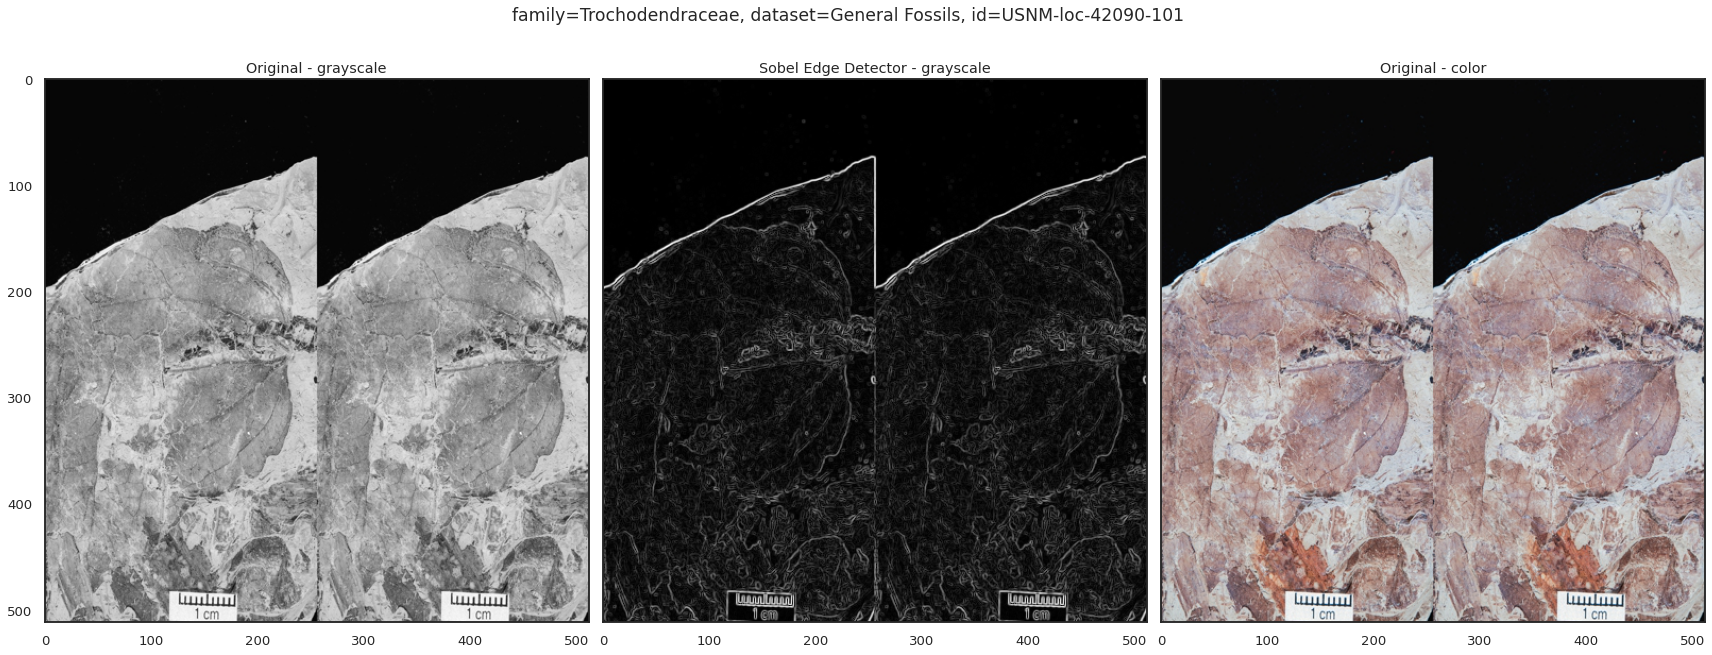

In [43]:
idx = 0

img = dataset[idx][0]
row = dataset.samples_df.iloc[idx]

plot_edge_detections_sobel(img=img)
plt.suptitle(f"family={row.family}, dataset={row.collection}, id={row.catalog_number}")

In [13]:
out_dir = os.path.join(output_dir, image_file_config.full_name)
os.makedirs(out_dir, exist_ok=True)

csv_out_path = os.path.join(out_dir, f"{image_file_config.full_name}-full_dataset.csv")
image_file_config_out_path = os.path.join(out_dir,"ImageFileDataset-config.yaml")
csv_config_out_path = os.path.join(out_dir,"CSVDataset-config.yaml")

dataset = ImageFileDataset.from_config(image_file_config, subset_keys=['all'])

dataset

<data>:
	ImageFileDatasetConfig(base_dataset_name='Extant', class_type='family', threshold=100, resolution=512, version='v1_0', path_schema='{family}_{genus}_{species}_{collection}_{catalog_number}')
	root_dir: /media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/100/jpg
	subsets: 

In [19]:
dataset.samples_df.describe(include='all')

,path,family,genus,species,collection,catalog_number
count,21033,21033,21033,21033,21033,21033
unique,21033,58,3361,6522,4,21033
top,/media/data_cifs/projects/prj_fossils/data/pro...,Fabaceae,Quercus,mexicana,Wolfe,Hickey_3028
freq,1,2301,395,100,13542,1


In [20]:
Extract.df2csv(dataset.samples_df,
               path = csv_out_path)
image_file_config.save(image_file_config_out_path)

csv_config = CSVDatasetConfig(full_name = image_file_config.full_name,
                              data_path = csv_out_path,
                              subset_key = "all")

csv_config.save(csv_config_out_path)

print(f"[FINISHED] DATASET FULL NAME: {csv_config.full_name}")
print(f"Newly created dataset assets located at:  {out_dir}")
print(f'Contents: {os.listdir(out_dir)}')
csv_config

[FINISHED] DATASET FULL NAME: Extant_family_100_512
Newly created dataset assets located at:  /media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v1_0/Extant_family_100_512
Contents: ['Extant_family_100_512-full_dataset.csv', 'ImageFileDataset-config.yaml', 'CSVDataset-config.yaml']


<class 'lightning_hydra_classifiers.data.utils.make_catalogs.CSVDatasetConfig'>
full_name: Extant_family_100_512
data_path: /media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v1_0/Extant_family_100_512/Extant_family_100_512-full_dataset.csv
label_encoder_path: None
subset_key: all
num_samples: 21033

In [8]:
image_file_config.locate_files().keys()

dict_keys(['all'])

In [2]:
catalog.get('Extant_family_20_1024')

'/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/20/jpg'

In [7]:
catalog.versions['v1_0']['Extant_family_20_1024']  #["Fossil_2048"]

'/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/20/jpg'

## imports & functions

In [129]:
import rich
rich.pretty.install()



from dataclasses import dataclass
import rich
from typing import *


@dataclass
class available_datasets:
    
    versions = ["v0_3", "v1_0-prerelease"]
    
    def __getitem__(self, index):
        return self.versions[index]

    
    
    
    
@dataclass
class LeavesdbBase:

#     datasets = ["PNAS", "Extant", "Fossil"]
    
    def keys(self):
        return self.__dict__.keys()
        
    def __getitem__(self, index):
        return self.__dict__[index]
    

    @property
    def datasets(self):
        return {"PNAS":self.PNAS,
                "Extant":self.Extant,
                "Fossil":self.Fossil}
    
    def __repr__(self):
        return rich.pretty.pretty_repr(self.datasets)
    
    @property
    def PNAS(self):
        return {k:self[k] for k in self.keys() if k.startswith("PNAS")}
    
    @property
    def Extant(self):
        return {k:self[k] for k in self.keys() if k.startswith("Extant")}
    
    @property
    def Fossil(self):
        return {k:self[k] for k in self.keys() if k.startswith("Fossil")}
    
    
    
    


@dataclass
class Leavesdbv0_3(LeavesdbBase):

    
    PNAS_family_100_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512"
    PNAS_family_100_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_1024"
    PNAS_family_100_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_1536"
    PNAS_family_100_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_2048"
################################S
################################
    Extant_family_10_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/512"
    Extant_family_10_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1024"
    Extant_family_10_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1536"
    Extant_family_10_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/2048"
    Extant_family_20_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/512"
    Extant_family_20_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1024"
    Extant_family_20_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1536"
    Extant_family_20_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/2048"
    Extant_family_50_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/512"
    Extant_family_50_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1024"
    Extant_family_50_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1536"
    Extant_family_50_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/2048"
    Extant_family_100_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/512"
    Extant_family_100_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1024"
    Extant_family_100_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1536"
    Extant_family_100_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/2048"
################################
################################
    Wilf_Fossil_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
    Wilf_Fossil_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
    Wilf_Fossil_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
    Wilf_Fossil_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
    Florissant_Fossil_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil",
    Florissant_Fossil_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil",
    Florissant_Fossil_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil",
    Florissant_Fossil_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"
################################
################################
    Fossil_512: List[str] = None
    Fossil_1024: List[str] = None
    Fossil_1536: List[str] = None
    Fossil_2048: List[str] = None

    def __post_init__(self):
        
        self.Fossil_512: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
                                 "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil"]
        self.Fossil_1024: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
                                  "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil"]
        self.Fossil_1536: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
                                  "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil"]
        self.Fossil_2048: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
                                  "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"]
            
    @property
    def datasets(self):
        return {"PNAS":self.PNAS,
                "Extant":self.Extant,
                "Fossil":self.Fossil}
            
    def __repr__(self):
        return rich.pretty.pretty_repr(self.datasets)


@dataclass
class Leavesdbv1_0(LeavesdbBase):

    
#     PNAS_family_100_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_512"
#     PNAS_family_100_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_1024"
#     PNAS_family_100_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_1536"
#     PNAS_family_100_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100_2048"
# ################################S
# ################################
#     Extant_family_10_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/512"
#     Extant_family_10_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1024"
#     Extant_family_10_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1536"
#     Extant_family_10_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/2048"
#     Extant_family_20_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/512"
#     Extant_family_20_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1024"
#     Extant_family_20_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1536"
#     Extant_family_20_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/2048"
#     Extant_family_50_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/512"
#     Extant_family_50_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1024"
#     Extant_family_50_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1536"
#     Extant_family_50_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/2048"
#     Extant_family_100_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/512"
#     Extant_family_100_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1024"
#     Extant_family_100_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1536"
#     Extant_family_100_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/2048"
# ################################
# ################################
#     Wilf_Fossil_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
#     Wilf_Fossil_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
#     Wilf_Fossil_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
#     Wilf_Fossil_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
#     Florissant_Fossil_512: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil",
#     Florissant_Fossil_1024: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil",
#     Florissant_Fossil_1536: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil",
#     Florissant_Fossil_2048: str = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"
# ################################
# ################################
#     Fossil_512: List[str] = None
#     Fossil_1024: List[str] = None
#     Fossil_1536: List[str] = None
#     Fossil_2048: List[str] = None

#     def __post_init__(self):
        
#         self.Fossil_512: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
#                                  "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil"]
#         self.Fossil_1024: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
#                                   "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil"]
#         self.Fossil_1536: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
#                                   "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil"]
#         self.Fossil_2048: List[str] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
#                                   "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"]
            
    @property
    def datasets(self):
        return {"PNAS":self.PNAS,
                "Extant":self.Extant,
                "Fossil":self.Fossil}
            
    def __repr__(self):
        return rich.pretty.pretty_repr(self.datasets)
    
    
    
    
    
    
    
    
    
leavesdbv0_3 = Leavesdbv0_3()
leavesdbv1_0 = Leavesdbv1_0()

# leavesdbv1_0

# leavesdbv0_3#.__annotations__

# leavesdbv0_3.datasets

# leavesdbv0_3.PNAS

# leavesdbv0_3.Extant

# leavesdbv0_3.Fossil

# for k in leavesdbv0_3:
#     print(k)

# # leavesdbv0_3.__dict__['Fossil_512']
# [leavesdbv0_3['Fossil_512'],
#  leavesdbv0_3['Fossil_1024']]

# v0_3 = leavesdbv0_3

# dir(v0_3) #.__dataclass_fields__)
# # v0_3.__dataclass_fields__
# # v0_3.__dataclass_params__
# # v0_3.__annotations__
# v0_3.__dict__

# pp(leavesdbv0_3())

# from rich import print as pp

# pp(leavesdbv0_3())

available_datasets = {"Extant_family_10_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/512",
                      "Extant_family_10_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1024",
                      "Extant_family_10_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/1536",
                      "Extant_family_10_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10/2048",
                     
                     "Extant_family_20_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/512",
                     "Extant_family_20_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1024",
                     "Extant_family_20_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/1536",
                     "Extant_family_20_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_20/2048",
                     
                     "Extant_family_50_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/512",
                     "Extant_family_50_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1024",
                     "Extant_family_50_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/1536",
                     "Extant_family_50_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_50/2048",
                     
                     "Extant_family_100_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/512",
                     "Extant_family_100_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1024",
                     "Extant_family_100_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/1536",
                     "Extant_family_100_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_100/2048"}

available_datasets = {
    "Wilf_Fossil_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
    "Wilf_Fossil_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
    "Wilf_Fossil_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
    "Wilf_Fossil_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
    
    "Florissant_Fossil_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil",
    "Florissant_Fossil_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil",
    "Florissant_Fossil_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil",
    "Florissant_Fossil_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"
}

available_datasets["Fossil_512"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
                                    "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil"]
available_datasets["Fossil_1024"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil"]
available_datasets["Fossil_1536"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil"]
available_datasets["Fossil_2048"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"]
    
    
    
    
    

available_datasets()[0]#.versions

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
import torchvision, torch, time
from PIL import Image
from MapExtrackt import FeatureExtractor

from lightning_hydra_classifiers.data.utils.make_catalogs import *

import numpy as np
from rising.loading import DataLoader
from tqdm.notebook import trange, tqdm

from torchvision import transforms
import time

import copy
from rich import print as pp



def train_model(model, dataloaders, criterion, optimizer, scheduler, monitor, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            monitor_update = 0
            
            for i, batch in tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=phase):
                x, y = batch[:2]
#                 x, y = x.cuda(non_blocking=pin_memory), y.cuda(non_blocking=pin_memory)
                x, y = x.to(device, non_blocking=pin_memory), y.to(device, non_blocking=pin_memory)

                if phase == "train":
                    monitor_update += 1
                    if monitor_update % 10 == 0:
                        monitor.start()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, y)
                                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * x.shape[0]
                running_corrects += torch.sum(preds == y.data)
            if phase == 'train':
                scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model,
                    dataloaders,
                    class_names,
                    num_images=6,
                    pin_memory=True):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        
        st = time.time()
        for i, batch in tqdm(enumerate(dataloader['val']), total=len(dataloader)): #leave=False, position=1, total=len(dataloader)):
            x, y = batch[:2]
            x, y = x.cuda(non_blocking=pin_memory), y.cuda(non_blocking=pin_memory)
            
            outputs = model(x)
            _, preds = torch.max(outputs, 1)        
        
            for j in range(x.shape[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(toPIL(x.cpu()).data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    end_time = time.time() - st
                    return f"visualize_model()\nTotal duration: {end_time-st:.2f} seconds"                
                
            model.train(mode=was_training)
            end_time = time.time() - st
            return f"visualize_model()\nTotal duration: {end_time-st:.2f} seconds"


### Working code

In [ ]:
# output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
# A_minus_B_dir = Path(output_dir, "Extant_family_10_512_minus_PNAS_family_100_512")

# config_path = list(A_minus_B_dir.glob("./CSVDataset-config.yaml"))[0]
# dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
# print("config path: \n\t", config_path)
# print("dataset path: \n\t", dataset_path)
# config = CSVDatasetConfig.load(path = config_path)
# dataset = CSVDataset.from_config(config)

In [ ]:
import collections
return_signature = ["image","target"]

output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
A_minus_B_dir = Path(output_dir, "Extant_family_10_512_minus_PNAS_family_100_512")

config_path = list(A_minus_B_dir.glob("./CSVDataset-config.yaml"))[0]
dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
# print("config path: \n\t", config_path)
# print("dataset path: \n\t", dataset_path)
config = CSVDatasetConfig.load(path = config_path)
dataset = CSVDataset.from_config(config)

##########################################
# print(config)
print(dataset)

extant_minus_pnas_dataset = dataset
data_splits = DataSplitter.create_trainvaltest_splits(data=extant_minus_pnas_dataset,
                                                      val_split=0.2,
                                                      test_split="test",
                                                      shuffle=True,
                                                      seed=3654,
                                                      stratify=True)

for k, v in data_splits.items():
    print(k, len(v))
    v._return_signature = collections.namedtuple("return_signature", return_signature)

In [ ]:
# train_dataset = data_splits['train']
# val_dataset = data_splits['val']

class_names = data_splits['train'].label_encoder.classes

pin_memory = True
batch_size = 12 # 1024 # bigger memory transfers to make their cost more noticable
num_workers = 0 # parallel workers to free up the main thread and reduce data decoding overhead


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


dataloaders = {subset: DataLoader(data_splits[subset],
                                  batch_size=batch_size,
#                                   sample_transforms=data_transforms[subset],
                                  shuffle=True,
                                  num_workers=num_workers)
              for subset in ['train', 'val']}

for subset in ['train', 'val']:
    data_splits[subset].transform = data_transforms[subset]

dataset_sizes = {subset: len(data_splits[subset]) for subset in ['train', 'val']}
class_names = data_splits['train'].label_encoder.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f'device: {device}')

In [ ]:
# b[0][0].shape
# len(b[1])
# b = [data_splits['train'][b] for b in range(10)]
# b

b = next(iter(dataloaders['train']))
b

In [ ]:
b[0].shape

In [ ]:
# Creating a monitoring object for visualzing feature maps.
from laymon import FeatureMapMonitoring
from torch import nn
num_classes = len(class_names)


fMonitor = FeatureMapMonitoring()
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

In [18]:
dir(fMonitor.monitor.get_registered_observers()['fc'])

dir(fMonitor.monitor)

dir(fMonitor)

In [ ]:
unfreeze_from_layer = 'layer4'

for name, param in model_ft.named_parameters():
    if name.startswith(unfreeze_from_layer):
        break
    param.requires_grad = False
        
# pp([f"{name}-> frozen: {c.requires_grad}" for name, c in model_ft.named_children()])

pp([f"{name}-> frozen: {c.requires_grad}" for name, c in model_ft.named_parameters()])

In [ ]:
dir(fMonitor)

In [ ]:
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# fMonitor.add_model(model_ft.layer4)
fMonitor.add_layer(model_ft.layer4, "layer4")
fMonitor.add_layer(model_ft.fc, "fc")
# Get the list of layers being visualized and their corresponding observer hook objects.
fMonitor.monitor.get_registered_observers()


model_ft = train_model(model_ft,
                       dataloaders, 
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler, 
                       monitor=fMonitor,
                       num_epochs=1)

visualize_model(model=model_ft,
                dataloaders=dataloaders,
                class_names=class_names,
                num_images=batch_size-1,
                pin_memory=True)

In [ ]:


model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)






model = torchvision.models.vgg19(pretrained=True)
fe = FeatureExtractor(model)

# import torch

# def toPIL(img: torch.Tensor, mode="RGB") -> Callable:
#     return torchvision.transforms.ToPILImage(mode)(img)

# img = toPIL(dataset[0][0])

# fe.set_image(img)

# gray_img = toPIL(dataset[0][0], "HSV")
# fe.set_image(gray_img)

# fe.display_from_map(layer_no=1)

# fe[38,:]

# batch_size = 32
# num_workers = 0

# dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
# batch = next(iter(dataloader))
# len(dataloader)
# for idx, batch in enumerate(iter(dataloader)):

# batch_size = 32
# num_workers = 0
# dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
# dataloader

pin_memory = True
batch_size = 64 # 1024 # bigger memory transfers to make their cost more noticable
num_workers = 6 # parallel workers to free up the main thread and reduce data decoding overhead


dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
# dataloader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     pin_memory=pin_memory,
#     num_workers=n_workers
# )

print('pin_memory:', pin_memory)
times = []
num_runs = 2

def work():
    # emulates the CPU work done
    time.sleep(0.05)


for i in trange(num_runs, position=0):
    st = time.time()
    for i, batch in tqdm(enumerate(dataloader), leave=False, position=1, total=len(dataloader)):
        x, y = batch[:2]
        x, y = x.cuda(non_blocking=pin_memory), y.cuda(non_blocking=pin_memory)
        work()
    times.append(time.time() - st)
    

print(f"{num_runs} Epoch(s):", "\n"+"=="*15)
print('Time:')
print(f"\tAvg: {np.mean(times):.2f} seconds")
print(f"\tStd: {np.std(times):.2f}")

## Avalanche continual datasets interlude

In [14]:
# from IPython.core.interactiveshell import InteractiveShell
# # pretty print all cell's output and not just the last one
# InteractiveShell.ast_node_interactivity = "all"

# import os

# if 'TOY_DATA_DIR' not in os.environ: 
#     os.environ['TOY_DATA_DIR'] = "/media/data_cifs/projects/prj_fossils/data/toy_data"
        
# default_root_dir = os.environ['TOY_DATA_DIR']


# import pandas as pd

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_colwidth', 200)


# # import continuum
# from torchvision.datasets import CIFAR10

# # from continuum.datasets import PyTorchDataset
# # dataset = PyTorchDataset("/my/data/folder/", dataset_type=CIFAR10, train=True, download=True)


# import torch
# import torchvision
# from avalanche.benchmarks.datasets import MNIST #, FashionMNIST, KMNIST, EMNIST, \
# # QMNIST, FakeData, CocoCaptions, CocoDetection, LSUN, ImageNet, CIFAR10, \
# # CIFAR100, STL10, SVHN, PhotoTour, SBU, Flickr8k, Flickr30k, VOCDetection, \
# # VOCSegmentation, Cityscapes, SBDataset, USPS, Kinetics400, HMDB51, UCF101, \
# # CelebA, CORe50, TinyImagenet, CUB200, OpenLORIS
# from avalanche.benchmarks.classic import SplitMNIST
# # As we would simply do with any Pytorch dataset we can create the train and 
# # test sets from it. We could use any of the above imported Datasets, but let's
# # just try to use the standard MNIST.
# train_MNIST = MNIST(
#     default_root_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
# )
# test_MNIST = MNIST(
#     default_root_dir, train=False, download=True, transform=torchvision.transforms.ToTensor()
# )

# # Given these two sets we can simply iterate them to get the examples one by one
# for i, example in enumerate(train_MNIST):
#     pass
# print("Num. examples processed: {}".format(i))

# # or use a Pytorch DataLoader
# train_loader = torch.utils.data.DataLoader(
#     train_MNIST, batch_size=32, shuffle=True
# )
# for i, (x, y) in enumerate(train_loader):
#     pass
# print("Num. mini-batch processed: {}".format(i))

# split_mnist = SplitMNIST(n_experiences=5, seed=1, dataset_root=default_root_dir)

# # Original train/test sets
# print('--- Original datasets:')
# print(split_mnist.original_train_dataset)
# print(split_mnist.original_test_dataset)

# dir(split_mnist)

# # A list describing which training patterns are assigned to each experience.
# # Patterns are identified by their id w.r.t. the dataset found in the
# # original_train_dataset field.
# print('--- Train patterns assignment:')
# print(split_mnist.train_exps_patterns_assignment)

# # A list describing which test patterns are assigned to each experience.
# # Patterns are identified by their id w.r.t. the dataset found in the
# # original_test_dataset field
# print('--- Test patterns assignment:')
# print(split_mnist.test_exps_patterns_assignment)

# # the task label of each experience.
# print('--- Task labels:')
# print(split_mnist.task_labels)

# # train and test streams
# print('--- Streams:')
# print(split_mnist.train_stream)
# print(split_mnist.test_stream)

# # A list that, for each experience (identified by its index/ID),
# # stores a set of the (optionally remapped) IDs of classes of patterns
# # assigned to that experience.
# print('--- Classes in each experience:')
# split_mnist.classes_in_experience


# # each stream has a name: "train" or "test"
# train_stream = split_mnist.train_stream
# print(train_stream.name)

# # we have access to the scenario from which the stream was taken
# train_stream.benchmark

# # we can slice and reorder the stream as we like!
# substream = train_stream[0]
# # print(len(substream))
# substream = train_stream[0:2]
# print(len(substream))
# substream = train_stream[0,2,1]

# print(len(substream))

# substream

# # we get the first experience
# experience = train_stream[0]

# # task label and dataset are the main attributes
# t_label = experience.task_label
# dataset = experience.dataset

# # but you can recover additional info
# experience.current_experience

# experience.classes_in_this_experience

# experience.classes_seen_so_far
# experience.previous_classes
# experience.future_classes
# experience.origin_stream
# experience.benchmark

# # As always, we can iterate over it normally or with a pytorch
# # data loader.
# # For instance, we can use tqdm to add a progress bar.
# from tqdm import tqdm
# for i, data in enumerate(tqdm(dataset)):
#     pass
# print("\nNumber of examples:", i + 1)
# print("Task Label:", t_label)

# from avalanche.benchmarks.classic import PermutedMNIST # CORe50, SplitTinyImageNet, \
# # SplitCIFAR10, SplitCIFAR100, SplitCIFAR110, SplitMNIST, RotatedMNIST, \
# # SplitCUB200, SplitImageNet

# # creating PermutedMNIST (Task-Incremental)
# # perm_mnist = PermutedMNIST(
# #     n_experiences=2,
# #     seed=1234,
# # )

# # creating the benchmark instance (scenario object)
# perm_mnist = PermutedMNIST(dataset_root=default_root_dir,
#                            n_experiences=3,
#                            seed=1234,
#                            )

# # recovering the train and test streams
# train_stream = perm_mnist.train_stream
# test_stream = perm_mnist.test_stream

# # iterating over the train stream
# for i, experience in enumerate(train_stream):
#     print(f'loop # {i}')
#     print("Start of task ", experience.task_label)
#     print('Classes in this task:', experience.classes_in_this_experience)

#     # The current Pytorch training set can be easily recovered through the
#     # experience
#     current_training_set = experience.dataset
#     # ...as well as the task_label
#     print('Task {}'.format(experience.task_label))
#     print('This task contains', len(current_training_set), 'training examples')

#     # we can recover the corresponding test experience in the test stream
#     current_test_set = test_stream[experience.current_experience].dataset
#     print('This task contains', len(current_test_set), 'test examples')

# Create Extant_minus_PNAS and PNAS_minus_Extant

In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import os

if 'TOY_DATA_DIR' not in os.environ: 
    os.environ['TOY_DATA_DIR'] = "/media/data_cifs/projects/prj_fossils/data/toy_data"
        
default_root_dir = os.environ['TOY_DATA_DIR']
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark
import avalanche
import torch
import torchvision
from avalanche.benchmarks.datasets import MNIST, CIFAR10 #, FashionMNIST, KMNIST, EMNIST, \
# QMNIST, FakeData, CocoCaptions, CocoDetection, LSUN, ImageNet, , \

from avalanche.benchmarks.utils import AvalancheDataset
from lightning_hydra_classifiers.data.utils import make_catalogs
from lightning_hydra_classifiers.utils.common_utils import (LabelEncoder,
                                                            trainval_split,
                                                            trainvaltest_split,
                                                            plot_split_distributions,
                                                            plot_class_distributions)
import torchdata
from lightning_hydra_classifiers.data.utils.make_catalogs import *

## Load and preprocess pre-formatted csv datasets and create train val test splits

In [10]:
eager_encode_targets = False

output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
A_minus_B_dir = Path(output_dir, "Extant_family_10_512_minus_PNAS_family_100_512")


config_path = list(A_minus_B_dir.glob("./CSVDataset-config.yaml"))[0]
dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
config = CSVDatasetConfig.load(path = config_path)
dataset = CSVDataset.from_config(config, eager_encode_targets=eager_encode_targets)

##########################################
print(config)
print(dataset)
extant_minus_pnas_dataset = dataset
A_minus_B_data_splits = DataSplitter.create_trainvaltest_splits(data=extant_minus_pnas_dataset,
                                                      val_split=0.2,
                                                      test_split="test",
                                                      shuffle=True,
                                                      seed=3654,
                                                      stratify=True)

test_config_path = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/A_in_B-CSVDataset-config.yaml"
test_config = CSVDatasetConfig.load(path = test_config_path)
test_dataset = CSVDataset.from_config(test_config, eager_encode_targets=eager_encode_targets)
A_minus_B_data_splits['test'] = test_dataset



# train_task0 = AvalancheDataset(A_minus_B_data_splits['train'], task_labels=0)
# val_task0 = AvalancheDataset(A_minus_B_data_splits['val'], task_labels=0)
# test_task0 = AvalancheDataset(A_minus_B_data_splits['test'], task_labels=0)
output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
B_minus_A_dir = Path(output_dir, "PNAS_family_100_512_minus_Extant_family_10_512")
config_path = list(B_minus_A_dir.glob("./CSVDataset-config.yaml"))[0]
# dataset_path = list(B_minus_A_dir.glob("./*full_dataset.csv"))[0]
# print("dataset path: \n\t", dataset_path)
config = CSVDatasetConfig.load(path = config_path)
dataset = CSVDataset.from_config(config)

##########################################
print(config)
print(dataset)

pnas_minus_extant_dataset = dataset
B_minus_A_data_splits = DataSplitter.create_trainvaltest_splits(data=pnas_minus_extant_dataset,
                                                      val_split=0.2,
                                                      test_split="test",
                                                      shuffle=True,
                                                      seed=3654,
                                                      stratify=True)

test_config_path = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/PNAS_family_100_512_minus_Extant_family_10_512/A_in_B-CSVDataset-config.yaml"
test_config = CSVDatasetConfig.load(path = test_config_path)
test_dataset = CSVDataset.from_config(test_config)

B_minus_A_data_splits['test'] = test_dataset

# dir(avalanche.benchmarks.utils)
# B_minus_A_data_splits

# train_task1 = AvalancheDataset(B_minus_A_data_splits['train'], task_labels=1)
# val_task1 = AvalancheDataset(B_minus_A_data_splits['val'], task_labels=1)
# test_task1 = AvalancheDataset(B_minus_A_data_splits['test'], task_labels=1)

# for sub in ['train', 'val', 'test']:
#     print(f"{sub}:")
#     print(len(A_minus_B_data_splits[sub].targets))
#     print(len(B_minus_A_data_splits[sub].targets))
    
#     print(type(A_minus_B_data_splits[sub].targets[0]))
#     print(type(B_minus_A_data_splits[sub].targets[0]))


len(A_minus_B_data_splits['test'].targets)
len(B_minus_A_data_splits['test'].targets)


len(set(A_minus_B_data_splits['test'].targets))
len(set(B_minus_A_data_splits['test'].targets))

## Reformat data subsets from each dataset into task_0 and task_1 format. Export all into multi-task format

In [26]:
replace_class_indices = {"Nothofagaceae":"Fagaceae"}

experiment_dir = "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/experiments_August_2021/Extant-to-PNAS-512-transfer_benchmark"
os.makedirs(experiment_dir, exist_ok=True)
task_0 = A_minus_B_data_splits
task_1 = B_minus_A_data_splits

task_0_label_encoder = task_0['train'].label_encoder
task_0_label_encoder.__init__( #task_0_label_encoder.class2idx,
                              replace = replace_class_indices)

task_0_label_encoder.fit(task_0['test'].targets)
len(task_0_label_encoder.classes)
task_0_label_encoder.fit(task_0['train'].targets)
len(task_0_label_encoder.classes)

task_0['val'].label_encoder = task_0_label_encoder
task_0['test'].label_encoder = task_0_label_encoder

# task_0['val'].label_encoder = task_0_label_encoder
# task_0['test'].label_encoder = task_0_label_encoder
# task_0 = A_minus_B_data_splits
# task_0_label_encoder = task_0['train'].label_encoder

task_0_dir = Path(experiment_dir, "task_0")
os.makedirs(task_0_dir, exist_ok=True)
for subset in ["train","val","test"]:
    task_0[subset].setup(samples_df=task_0[subset].samples_df,
                         label_encoder=task_0[subset].label_encoder,
                         fit_targets=False)

    CSVDatasetConfig.export_dataset_state(output_dir=task_0_dir, # / subset,
                                          df=task_0[subset].samples_df,
                                          config=task_0[subset].config,
                                          encoder=task_0_label_encoder,
                                          dataset_name=subset)
# len(set(B_minus_A_data_splits['test'].targets))

replace_class_indices = {"Nothofagaceae":"Fagaceae"}

experiment_dir = "/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/experiments_August_2021/Extant-to-PNAS-512-transfer_benchmark"
os.makedirs(experiment_dir, exist_ok=True)

task_1_label_encoder = task_1['train'].label_encoder
task_1_label_encoder.__init__(#task_1_label_encoder.class2idx,
                              replace = replace_class_indices)


task_1_label_encoder.fit(task_1['test'].targets)
len(task_1_label_encoder.classes)
task_1_label_encoder.fit(task_1['train'].targets)
len(task_1_label_encoder.classes)


task_1['val'].label_encoder = task_1_label_encoder
task_1['test'].label_encoder = task_1_label_encoder
# task_1 = A_minus_B_data_splits
# task_1_label_encoder = task_1['train'].label_encoder

task_1_dir = Path(experiment_dir, "task_1")
os.makedirs(task_1_dir, exist_ok=True)
for subset in ["train","val","test"]:
    
    task_1[subset].setup(samples_df=task_1[subset].samples_df,
                         label_encoder=task_1[subset].label_encoder,
                         fit_targets=False)

    CSVDatasetConfig.export_dataset_state(output_dir=task_1_dir, # / subset,
                                          df=task_1[subset].samples_df,
                                          config=task_1[subset].config,
                                          encoder=task_1_label_encoder,
                                          dataset_name=subset)
# len(set(B_minus_A_data_splits['test'].targets))

# Import and preprocess datasets for training

In [13]:
experiment_dir = Path("/media/data/jacob/GitHub/lightning-hydra-classifiers/notebooks/experiments_August_2021/Extant-to-PNAS-512-transfer_benchmark")
task_0_dir = experiment_dir / "task_0"
task_1_dir = experiment_dir / "task_1"
task_0, task_1 = {}, {}

for subset in ["train","val","test"]:
    task_0[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_0_dir / f"{subset}.yaml")
    task_1[subset], _ = CSVDatasetConfig.import_dataset_state(config_path = task_1_dir / f"{subset}.yaml")

task_0["train"][0][0]
task_0["val"][0][0]
task_0["test"][0][0]

task_1["train"][0][0]
task_1["val"][0][0]
task_1["test"][0][0]

### Create transforms

In [14]:
from torchvision import transforms
from typing import *


totensor: Callable = torchvision.transforms.ToTensor()

def toPIL(img: torch.Tensor, mode="RGB") -> Callable:
    return torchvision.transforms.ToPILImage(mode)


def normalize_transform(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225]) -> Callable:
    return transforms.Normalize(mean=mean,
                                std=std)

def default_train_transforms(image_size: int=224,
                             normalize: bool=True, 
                             augment:bool=True,
                             grayscale: bool=True,
                             channels: Optional[int]=3,
                             mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225]):
    """Subclasses can override this or user can provide custom transforms at runtime"""
    transform_list = []
#         transform_jit_list = []
    resize_PIL = not augment
    if augment:
        transform_list.extend([transforms.RandomResizedCrop(size=image_size,
                                                            scale=(0.25, 1.2),
                                                            ratio=(0.7, 1.3),
                                                            interpolation=2),
                               totensor
                             ])
    return default_eval_transforms(image_size=image_size,
                                        normalize=normalize,
                                        resize_PIL=resize_PIL,
                                        grayscale=grayscale,
                                        channels=channels,
                                        transform_list=transform_list,
                                        mean=mean,
                                        std=std)

def default_eval_transforms(image_size: int=224,
                            image_buffer_size: int=32,
                            normalize: bool=True,
                            resize_PIL: bool=True,
                            grayscale: bool=True,
                            channels: Optional[int]=3,
                            transform_list: Optional[List[Callable]]=None,
                            mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225]):
    """Subclasses can override this or user can provide custom transforms at runtime"""
    transform_list = transform_list or []
    transform_jit_list = []

    if resize_PIL:
        # if True, assumes input images are PIL.Images (But need to check if this even matters.)
        # if False, expects input images to already be torch.Tensors
        transform_list.extend([transforms.Resize(image_size+image_buffer_size),
                               transforms.CenterCrop(image_size),
                               totensor])
    if normalize:
        transform_jit_list.append(normalize_transform(mean, std))

    if grayscale:
        transform_jit_list.append(transforms.Grayscale(num_output_channels=channels))

    return transforms.Compose([*transform_list, *transform_jit_list])


def get_default_transforms(image_size: int=224,
                           normalize: bool=True,
                           augment:bool=True,
                           grayscale: bool=True,
                           channels: Optional[int]=3,
                           mean = [0.485, 0.456, 0.406],
                           std = [0.229, 0.224, 0.225]):

    
    train_transform = default_train_transforms(image_size=image_size,
                                               normalize=normalize,
                                               augment=augment,
                                               grayscale=grayscale,
                                               channels=channels,
                                               mean=mean,
                                               std=std)
    eval_transform = default_eval_transforms(image_size=image_size,
                                             image_buffer_size=32,
                                             normalize=normalize,
                                             resize_PIL=not augment,
                                             grayscale=grayscale,
                                             channels=channels,
                                             transform_list=None,
                                             mean=mean,
                                             std=std)
    
    
    
    return train_transform, eval_transform

In [15]:
train_transform, val_transform = get_default_transforms(image_size=224,
                                                         normalize=True,
                                                         augment=True,
                                                         grayscale=True,
                                                         channels=3,
                                                         mean = [0.485, 0.456, 0.406],
                                                         std = [0.229, 0.224, 0.225])

### Assemble Avalanche Datasets for task 0 and task 1

In [20]:
avalanche_tasks = {0: {},
                   1: {}}

transforms = {"train":train_transform,
              "val": val_transform,
              "test": val_transform}

for subset in ['train','val','test']:
    avalanche_tasks[0][subset] = AvalancheDataset(task_0[subset], task_labels=0, transform=transforms[subset])
    avalanche_tasks[1][subset] = AvalancheDataset(task_1[subset], task_labels=1, transform=transforms[subset])


In [21]:
avalanche_tasks

{0: {'train': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afb97e610>,
  'val': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afb97e130>,
  'test': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afb97edc0>},
 1: {'train': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afb97ec10>,
  'val': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afbba6a90>,
  'test': <avalanche.benchmarks.utils.avalanche_dataset.AvalancheDataset at 0x7f8afb97eb50>}}

In [ ]:
train_task0 = AvalancheDataset(A_minus_B_data_splits['train'], task_labels=0)#, transform=train_transform)
val_task0 = AvalancheDataset(A_minus_B_data_splits['val'], task_labels=0) #, transform=eval_transform)
test_task0 = AvalancheDataset(A_minus_B_data_splits['test'], task_labels=0) #, transform=eval_transform)

#########################################

train_task1 = AvalancheDataset(B_minus_A_data_splits['train'], task_labels=1) #, transform=train_transform)
val_task1 = AvalancheDataset(B_minus_A_data_splits['val'], task_labels=1) #, transform=eval_transform)
test_task1 = AvalancheDataset(B_minus_A_data_splits['test'], task_labels=1) #, transform=eval_transform)

In [10]:
from avalanche.benchmarks.generators import dataset_benchmark

In [22]:


scenario = dataset_benchmark([avalanche_tasks[0]["train"], avalanche_tasks[1]["train"]],
                             [avalanche_tasks[0]["val"], avalanche_tasks[1]["val"]],
                             train_transform=train_transform,
                             eval_transform=eval_transform)

In [11]:
# scenario = dataset_benchmark([train_task0, train_task1],
#                              [val_task0, val_task1],
#                             train_transform=train_transform,
#                             eval_transform=eval_transform)

# Scratch

In [30]:
len(scenario.train_stream[0].classes_in_this_experience)

len(scenario.train_stream[1].classes_in_this_experience)

scenario.train_stream[1].origin_stream.name == scenario.train_stream[0].origin_stream.name
# scenario.train_stream.name

dir(scenario.train_stream[1].dataset)

scenario.train_stream[1].dataset.transform

In [37]:
import torchvision
totensor: Callable = torchvision.transforms.ToTensor()

    
scenario.train_stream[1].dataset.transform = totensor


In [40]:
import torch
import numpy as np


# scenario.train_stream[1].dataset[0][0].numpy().shape
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[0,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[1,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[2,...])
torch.std(scenario.train_stream[1].dataset[0][0])

import torch
import numpy as np


# scenario.train_stream[1].dataset[0][0].numpy().shape
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[0,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[1,...])
np.mean(scenario.train_stream[1].dataset[0][0].numpy()[2,...])
torch.std(scenario.train_stream[1].dataset[0][0])

In [157]:

# e = toPIL(scenario.train_stream[0].dataset[0][0], mode="L")()
e = toPIL(None, mode="RGB")(scenario.train_stream[1].dataset[0][0])
e

dir(scenario.train_stream[0])

dir(scenario)

from dataclasses import dataclass
import dataclasses

dataclasses.asdict(test_config)

dir(test_config)

dir(dataclasses)

dataclasses.make_dataclass

dir(avalanche.benchmarks.utils.avalanche_dataset)#.ClassificationDataset)
# avalanche.benchmarks.utils.avalanche_dataset.ClassificationDataset()

from avalanche.benchmarks.generators import dataset_benchmark # , filelist_benchmark

scenario = dataset_benchmark([train_task0, train_task1],
                             [val_task0, val_task1])

# train_cifar10_task1 = AvalancheDataset(train_cifar10, task_labels=1)
# test_cifar10_task1 = AvalancheDataset(test_cifar10, task_labels=1)

# scenario_custom_task_labels = dataset_benchmark(
#     [train_MNIST_task0, train_cifar10_task1],
#     [test_MNIST_task0, test_cifar10_task1]
# )

# print('Without custom task labels:',
#       generic_scenario.train_stream[1].task_label)

print('With custom task labels:',
      [l.task_label for l in scenario.train_stream[1]])

len(scenario.train_stream)

dir(scenario)

print([len(l) for l in scenario.get_classes_timeline(0)])
print([len(l) for l in scenario.get_classes_timeline(1)])


# scenario.task_labels
# dir(scenario.streams['train'].benchmark)
scenario.streams['train'][0][0]

In [148]:
scenario.task_labels
dir(scenario.streams['train'])

dir(scenario_custom_task_labels)

## Creating a Benchmark

In [91]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop

In [130]:
train_task1[0]

# train_task1, val_task1, test_task1

scenario = ni_benchmark(
    train_task1, val_task1, n_experiences=2, shuffle=True, seed=1234)

train_stream = scenario.train_stream

for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')



train_transform = Compose([
    RandomCrop(28, padding=4),
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

test_transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

mnist_train = MNIST(
    default_root_dir, train=True, download=True, transform=train_transform
)
mnist_test = MNIST(
    default_root_dir, train=False, download=True, transform=test_transform
)



scenario = ni_benchmark(
    mnist_train, mnist_test, n_experiences=10, shuffle=True, seed=1234,
    balance_experiences=True
)

train_stream = scenario.train_stream

for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {} batch {} -> train'.format(t, exp_id))
    print('This batch contains', len(training_dataset), 'patterns')

In [109]:
dir(scenario) #.train_stream)

scenario.n_classes
scenario.n_experiences
scenario.n_patterns_per_class
scenario.n_patterns_per_experience

len(scenario.original_train_dataset)
scenario.get_classes_timeline(0)

dir(training_dataset)

len(training_dataset.task_set[0])

from avalanche.benchmarks.generators import dataset_benchmark # , filelist_benchmark

dataset_benchmark(train_task1, val_task1, test_task1)

# train_cifar10_task1 = AvalancheDataset(train_cifar10, task_labels=1)
# test_cifar10_task1 = AvalancheDataset(test_cifar10, task_labels=1)

scenario_custom_task_labels = dataset_benchmark(
    [train_MNIST_task0, train_cifar10_task1],
    [test_MNIST_task0, test_cifar10_task1]
)

print('Without custom task labels:',
      generic_scenario.train_stream[1].task_label)

print('With custom task labels:',
      scenario_custom_task_labels.train_stream[1].task_label)

## scratch

In [85]:
dir(train_task1)

train_task0.task_set

train_task1.task_set

In [68]:
def create_dataset_A_in_B(dataset_A,
                          dataset_B) -> pd.DataFrame:
    
    A_w_B = dataset_A.intersection(dataset_B)

    columns = [*[col for col in A_w_B.columns if col.endswith("_x")], *["catalog_number"]]
    A_in_B = A_w_B.reset_index()[columns].sort_values("catalog_number")

    print(f"A_in_B.columns: {A_in_B.columns}")
    A_in_B = A_in_B.rename(columns = {col: col.split("_x")[0] for col in A_in_B.columns})

    return A_in_B

In [69]:
csv_cfg_path_A = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/inputs/A/CSVDataset-config.yaml"
csv_cfg_path_B = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/inputs/B/CSVDataset-config.yaml"

csv_config_A = CSVDatasetConfig.load(path = csv_cfg_path_A)
csv_config_B = CSVDatasetConfig.load(path = csv_cfg_path_B)

dataset_A = CSVDataset.from_config(csv_config_A)
dataset_B = CSVDataset.from_config(csv_config_B)
    
    
A_in_B = create_dataset_A_in_B(dataset_A,
                               dataset_B)

B_in_A = create_dataset_A_in_B(dataset_B,
                               dataset_A)

A_in_B.head(5)

B_in_A.head(5)

In [ ]:
# def export_composite_dataset_catalog_configuration(output_dir: str = ".",
#                                                    csv_cfg_path_A: str=None,
#                                                    csv_cfg_path_B: str=None,
#                                                    composition: str="-") -> Tuple[CSVDataset, CSVDatasetConfig]:
    
    
#     csv_config_A = CSVDatasetConfig.load(path = csv_cfg_path_A)
#     csv_config_B = CSVDatasetConfig.load(path = csv_cfg_path_B)

#     dataset_A = CSVDataset.from_config(csv_config_A)
#     dataset_B = CSVDataset.from_config(csv_config_B)
#     print(f"num_samples A: {len(dataset_A)}")
#     print(f"num_samples B: {len(dataset_B)}")
    
#     print(f"producing composition: {composition}")
#     if composition == '-':
#         dataset_A_composed_B = dataset_A - dataset_B
#         full_name = f"{csv_config_A.full_name}_minus_{csv_config_B.full_name}"
#         out_dir = os.path.join(output_dir, full_name)
#         os.makedirs(out_dir, exist_ok=True)

#         print(f"num_samples A-B: {len(dataset_A_composed_B)}")
        
#         A_in_B = create_dataset_A_in_B(dataset_A,
#                                        dataset_B)

#         csv_dataset_pathname = f"{csv_config_A.full_name}_in_{csv_config_B.full_name}"
#         csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
#         csv_dataset_config_out_path = os.path.join(out_dir,f"A_in_B-CSVDataset-config.yaml")
# #         print(f"A_in_B.columns: {A_in_B.columns}")
#         Extract.df2csv(A_in_B,
#                        path = csv_dataset_out_path)
        
#         A_in_B_config = CSVDatasetConfig(full_name = csv_dataset_pathname,
#                                          csv_path = csv_dataset_out_path,
#                                          subset_key = "all")
#         A_in_B_config.save(csv_dataset_config_out_path)
        

        
#     if composition == 'intersection':
#         dataset_A_composed_B = dataset_A.intersection(dataset_B)
#         full_name = f"{csv_config_A.full_name}_w_{csv_config_B.full_name}"
#         print(f"num_samples A_w_B: {len(dataset_A_composed_B)}")
        
#         out_dir = os.path.join(output_dir, full_name)
#         os.makedirs(out_dir, exist_ok=True)

#         csv_dataset_pathname = f"{csv_config_A.full_name}_in_{csv_config_B.full_name}"
#         csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
#         csv_dataset_config_out_path = os.path.join(out_dir,f"A_in_B-CSVDataset-config.yaml")
#         A_in_B = create_dataset_A_in_B(dataset_A,
#                                        dataset_B)
# #         columns = [*[col for col in dataset_A_composed_B.columns if col.endswith("_x")], *["catalog_number"]]
# #         A_in_B = dataset_A_composed_B.reset_index()[columns].sort_values("catalog_number")
# #         A_in_B = A_in_B.loc[:,[*list(SampleSchema.keys())]]
# #         print(f"A_in_B.columns: {A_in_B.columns}")
# #         A_in_B = A_in_B.rename(columns = {col: col.split("_x")[0] for col in A_in_B.columns})
#         Extract.df2csv(A_in_B,
#                        path = csv_dataset_out_path)
#         A_in_B_config = CSVDatasetConfig(full_name = csv_dataset_pathname,
#                                          csv_path = csv_dataset_out_path,
#                                          subset_key = "all")
#         A_in_B_config.save(csv_dataset_config_out_path)
        
#         csv_dataset_pathname = f"{csv_config_B.full_name}_in_{csv_config_A.full_name}"
#         csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
#         csv_dataset_config_out_path = os.path.join(out_dir,f"B_in_A-CSVDataset-config.yaml")
#         B_in_A = create_dataset_A_in_B(dataset_B,
#                                        dataset_A)
# #         columns = [*[col for col in dataset_A_composed_B.columns if col.endswith("_y")], *["catalog_number"]]
# #         B_in_A = dataset_A_composed_B.reset_index()[columns].sort_values("catalog_number")
# #         B_in_A = B_in_A.loc[:,[*list(SampleSchema.keys())]]
# #         B_in_A = B_in_A.rename(columns = {col: col.split("_y")[0] for col in B_in_A.columns})
#         Extract.df2csv(B_in_A,
#                        path = csv_dataset_out_path)
#         B_in_A_config = CSVDatasetConfig(full_name = csv_dataset_pathname,
#                                          csv_path = csv_dataset_out_path,
#                                          subset_key = "all")
#         B_in_A_config.save(csv_dataset_config_out_path)
        
        
# #     out_dir = os.path.join(output_dir, full_name)
# #     os.makedirs(out_dir, exist_ok=True)

#     inputs_dir = os.path.join(out_dir, "inputs")
# #     os.makedirs(inputs_dir, exist_ok=True)
#     os.makedirs(os.path.join(inputs_dir, "A"), exist_ok=True)
#     os.makedirs(os.path.join(inputs_dir, "B"), exist_ok=True)
#     shutil.copyfile(csv_cfg_path_A, os.path.join(inputs_dir, "A", Path(csv_cfg_path_A).name))
#     shutil.copyfile(csv_cfg_path_B, os.path.join(inputs_dir, "B", Path(csv_cfg_path_B).name))

#     csv_dataset_pathname = f"{full_name}-full_dataset"
#     csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
#     csv_dataset_config_out_path = os.path.join(out_dir,f"CSVDataset-config.yaml")    

#     Extract.df2csv(dataset_A_composed_B,
#                    path = csv_dataset_out_path)
#     A_composed_B_config = CSVDatasetConfig(full_name = full_name,
#                                         csv_path = csv_dataset_out_path,
#                                         subset_key = "all")
#     A_composed_B_config.save(csv_dataset_config_out_path)

#     print(f"[FINISHED] DATASET: {full_name}")
#     print(f"Newly created dataset assets located at:  {out_dir}")
    
#     if composition == '-':
#         dataset_A_composed_B = CSVDataset.from_config(A_composed_B_config)
#         return dataset_A_composed_B, A_composed_B_config
        
#     if composition == 'intersection':
#         return (A_in_B, B_in_A), A_composed_B_config


In [57]:
train_cifar10_task1 = AvalancheDataset(train_cifar10, task_labels=1)
test_cifar10_task1 = AvalancheDataset(test_cifar10, task_labels=1)

scenario_custom_task_labels = dataset_benchmark(
    [train_MNIST_task0, train_cifar10_task1],
    [test_MNIST_task0, test_cifar10_task1]
)

print('Without custom task labels:',
      generic_scenario.train_stream[1].task_label)

print('With custom task labels:',
      scenario_custom_task_labels.train_stream[1].task_label)

NameError: name 'AvalancheDataset' is not defined

In [57]:

train_MNIST_task0 = AvalancheDataset(train_MNIST, task_labels=0)
test_MNIST_task0 = AvalancheDataset(test_MNIST, task_labels=0)

train_cifar10_task1 = AvalancheDataset(train_cifar10, task_labels=1)
test_cifar10_task1 = AvalancheDataset(test_cifar10, task_labels=1)

scenario_custom_task_labels = dataset_benchmark(
    [train_MNIST_task0, train_cifar10_task1],
    [test_MNIST_task0, test_cifar10_task1]
)

print('Without custom task labels:',
      generic_scenario.train_stream[1].task_label)

print('With custom task labels:',
      scenario_custom_task_labels.train_stream[1].task_label)

NameError: name 'AvalancheDataset' is not defined

In [49]:
train_MNIST = MNIST(
    default_root_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
)
test_MNIST = MNIST(
    default_root_dir, train=False, download=True, transform=torchvision.transforms.ToTensor()
)



train_cifar10 = CIFAR10(
    default_root_dir, train=True, download=True
)
test_cifar10 = CIFAR10(
    default_root_dir, train=False, download=True
)

generic_scenario = dataset_benchmark(
    [train_MNIST, train_cifar10],
    [test_MNIST, test_cifar10]
)

# dir(generic_scenario)

generic_scenario.streams
train_stream = generic_scenario.train_stream

In [51]:
# we get the first experience
experience = train_stream[0]

# task label and dataset are the main attributes
t_label = experience.task_label
dataset = experience.dataset

# but you can recover additional info
experience.current_experience

0

In [43]:
len(experience.classes_in_this_experience)

dir(experience.dataset)

In [56]:
experience.dataset.dataset_type

experience.dataset

dir(experience)

experience.classes_seen_so_far
experience.previous_classes
experience.future_classes
experience.origin_stream
experience.benchmark



## Developing train/val/test workflow

In [63]:
from lightning_hydra_classifiers.data.utils import make_catalogs

from lightning_hydra_classifiers.utils.common_utils import (LabelEncoder,
                                                            trainval_split,
                                                            trainvaltest_split,
                                                            plot_split_distributions,
                                                            plot_class_distributions)
import torchdata
from lightning_hydra_classifiers.data.utils.make_catalogs import *

In [64]:
output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
A_minus_B_dir = Path(output_dir, "Extant_family_10_512_minus_PNAS_family_100_512")

config_path = list(A_minus_B_dir.glob("./CSVDataset-config.yaml"))[0]
dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
config = CSVDatasetConfig.load(path = config_path)
dataset = CSVDataset.from_config(config)

##########################################
print(config)
print(dataset)

extant_minus_pnas_dataset = dataset
data_splits = DataSplitter.create_trainvaltest_splits(data=extant_minus_pnas_dataset,
                                                      val_split=0.2,
                                                      test_split="test",
                                                      shuffle=True,
                                                      seed=3654,
                                                      stratify=True)

config path: 
	 /media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/CSVDataset-config.yaml
dataset path: 
	 /media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/Extant_family_10_512_minus_PNAS_family_100_512-full_dataset.csv
<class 'lightning_hydra_classifiers.data.utils.make_catalogs.CSVDatasetConfig'>
full_name: Extant_family_10_512_minus_PNAS_family_100_512
csv_path: /media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512_minus_PNAS_family_100_512/Extant_family_10_512_minus_PNAS_family_100_512-full_dataset.csv
subset_key: all
num_samples: 22704
lightning_hydra_classifiers.data.utils.make_catalogs.CSVDataset
train 18163
val 4541
train 18163
val 4541


In [ ]:
config_A_path = list(A_minus_B_dir.glob("./inputs/A/*CSVDataset-config.yaml"))[0]
config_B_path = list(A_minus_B_dir.glob("./inputs/B/*CSVDataset-config.yaml"))[0]
config_A = CSVDatasetConfig.load(path = config_A_path)
config_B = CSVDatasetConfig.load(path = config_B_path)

# A_minus_B_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_100_512_minus_PNAS_family_100_512")
# output_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/")
# A_minus_B_dir = Path(output_dir, "Extant_family_10_512_minus_PNAS_family_100_512")

config_path = list(A_minus_B_dir.glob("./CSVDataset-config.yaml"))[0]
dataset_path = list(A_minus_B_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
A_composed_B_config = CSVDatasetConfig.load(path = config_path)
dataset_A_composed_B = CSVDataset.from_config(config)



full_name = f"{config_A.full_name}_w_{config_B.full_name}"
A_in_B_dir = Path(output_dir, full_name)
# print(f"num_samples A_w_B: {len(dataset_A_composed_B)}")
config_path = list(A_in_B_dir.glob("./*A_in_B-CSVDataset-config.yaml"))[0]
A_in_B_config = CSVDatasetConfig.load(path = config_path)
dataset_A_in_B = CSVDataset.from_config(A_in_B_config)

config_path = list(A_in_B_dir.glob("./*B_in_A-CSVDataset-config.yaml"))[0]
B_in_A_config = CSVDatasetConfig.load(path = config_path)
dataset_B_in_A = CSVDataset.from_config(B_in_A_config)


##################################

data_splits["test"] = dataset_A_in_B

In [ ]:
idx = 37
for k,v in data_splits.items():
    print(k)
    display(toPIL(v[idx][0]))

In [ ]:
idx = 48


display(toPIL(dataset_A_in_B[idx][0]))

display(toPIL(dataset_B_in_A[idx][0]))

In [ ]:
csv_dataset_pathname = f"{config_A.full_name}_in_{config_B.full_name}"
csv_dataset_out_path = os.path.join(out_dir, csv_dataset_pathname + ".csv")
dataset_config_path = os.path.join(A_in_B_dir,f"CSVDataset-config.yaml")


columns = ["catalog_number", *[col for col in dataset_A_composed_B.columns if col.endswith("_x")]]
extant_in_pnas = dataset_A_composed_B.reset_index()[columns].sort_values("catalog_number")
print(f"extant_in_pnas.columns: {extant_in_pnas.columns}")

extant_in_pnas = extant_in_pnas.rename(columns = {col: col.split("_x")[0] for col in extant_in_pnas.columns})
Extract.df2csv(extant_in_pnas,
               path = csv_dataset_out_path)

In [ ]:
config_path = list(A_minus_B_dir.glob("./inputs/B/*CSVDataset-config.yaml"))[0]

In [ ]:
config_path

In [ ]:
# pnas_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/PNAS_family_100_512")

# config_path = list(pnas_dir.glob("./*CSVDataset-config.yaml"))[0]
# dataset_path = list(pnas_dir.glob("./*full_dataset.csv"))[0]
# print("config path: \n\t", config_path)
# print("dataset path: \n\t", dataset_path)
pnas_config = CSVDatasetConfig.load(path = config_path)
pnas_dataset = CSVDataset.from_config(pnas_config)

##########################################
print(pnas_config)
print(pnas_dataset)

In [ ]:
# A_minus_B_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_100_512_minus_PNAS_family_100_512")
pnas_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/PNAS_family_100_512")

config_path = list(pnas_dir.glob("./*CSVDataset-config.yaml"))[0]
dataset_path = list(pnas_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
pnas_config = CSVDatasetConfig.load(path = config_path)
pnas_dataset = CSVDataset.from_config(pnas_config)

##########################################
print(pnas_config)
print(pnas_dataset)



# A_minus_B_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_100_512_minus_PNAS_family_100_512")
extant_dir = Path("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3/Extant_family_10_512")

config_path = list(extant_dir.glob("./*CSVDataset-config.yaml"))[0]
dataset_path = list(extant_dir.glob("./*full_dataset.csv"))[0]
print("config path: \n\t", config_path)
print("dataset path: \n\t", dataset_path)
extant_config = CSVDatasetConfig.load(path = config_path)
extant_dataset = CSVDataset.from_config(extant_config)

##########################################
print(extant_config)
print(extant_dataset)


# extant_w_pnas = extant_dataset.intersection(pnas_dataset, suffixes=("_extant", "_pnas"))
# extant_w_pnas = extant_w_pnas.sort_values(extant_dataset.id_col)
# extant_w_pnas

In [ ]:
def make_extant_w_pnas_v0_3():
    output_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/csv_datasets/leavesdb-v0_3"

    base_names = {"A": "Extant",
                  "B": "PNAS"}
    thresholds = [{"A":100,
                   "B":100},
                 {"A":10,
                   "B":100}]
    resolutions = [512, 1024]
    class_type = "family"


    for threshold in thresholds:
        for resolution in resolutions:
            dataset_full_names = {"A":"_".join([base_names["A"], class_type, str(threshold["A"]), str(resolution)]),
                                  "B":"_".join([base_names["B"], class_type, str(threshold["B"]), str(resolution)])}

            csv_cfg_path_A = os.path.join(output_dir, dataset_full_names["A"], "CSVDataset-config.yaml")
            csv_cfg_path_B = os.path.join(output_dir, dataset_full_names["B"], "CSVDataset-config.yaml")
            dataset, cfg = export_composite_dataset_catalog_configuration(output_dir=output_dir,
                                                                          csv_cfg_path_A=csv_cfg_path_A,
                                                                          csv_cfg_path_B=csv_cfg_path_B,
                                                                          composition="intersection")


    print(f'FINISHED ALL IN Extant_w_PNAS')
    print('=='*15)
    
    
    
make_extant_w_pnas_v0_3()

In [ ]:
extant_df = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Extant-dataset_leavesdb-v0_3.csv", index_col=0)
pnas_train = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/train.csv")
pnas_test = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/test.csv")
pnas_df = pd.concat([pnas_train, pnas_test])

extant_in_pnas = intersection(data_df=extant_df,
                              other_df=pnas_df,
                              id_col="catalog_number",
                              suffixes=("_extant", "_pnas"))

# In order to only keep original columns
suffixes=("_extant", "_pnas")
extant_in_pnas = extant_in_pnas.drop(columns = [c for c in extant_in_pnas.columns if c.endswith(suffixes[1])])
extant_in_pnas = extant_in_pnas.rename(columns = {c:c.split(suffixes[0])[0] for c in extant_in_pnas.columns})

In [ ]:
Code Editor out of Sync
Please open your browser JavaScript console for bug report instruction

In [ ]:
# data=dataset
# val_split=0.2
# test_split="test"
# shuffle=True
# seed=3654
# stratify=True

# if (test_split == "test") or (test_split is None):
#     train_split = 1 - val_split
#     if hasattr(data, f"test_dataset"):
#         data = getattr(data, f"train_dataset")            
# elif isinstance(test_split, float):
#     train_split = 1 - (test_split + val_split)
# else:
#     raise ValueError(f"Invalid split arguments: val_train_split={val_train_split}, test_split={test_split}")


# splits=(train_split, val_split, test_split)
# splits = list(filter(lambda x: isinstance(x, float), splits))
# y = data.targets

# if len(splits)==2:
#     data_splits = trainval_split(x=None,
#                                  y=y,
#                                  val_train_split=splits[-1],
#                                  random_state=seed,
#                                  stratify=stratify)

# else:
#     data_splits = trainvaltest_split(x=None,
#                                      y=y,
#                                      splits=splits,
#                                      random_state=seed,
#                                      stratify=stratify)

# for k,v in data_splits.items():
#     print(k, len(v[0]))

# dataset_splits={}
# for split, (split_idx, split_y) in data_splits.items():
#     print(split, len(split_idx))
#     dataset_splits[split] = data.filter(indices=split_idx, subset_key=split)

In [ ]:
# dataset_splits["train"]
dataset_splits["val"]

In [ ]:
train_idx, val_idx = data_splits['train'][0], data_splits['val'][0]

train_df = extant_minus_pnas.iloc[train_idx,:]
val_df = extant_minus_pnas.iloc[val_idx,:]

train_dataset_extant_minus_pnas = CommonDataset.from_dataframe(
                                                               sample_df=train_df,
                                                               config=None,
                                                               return_signature = ["image","target","path"],
                                                               subset_key="train")
#                                                                subset_key=None) #"train")


val_dataset_extant_minus_pnas = CommonDataset.from_dataframe(
                                                             sample_df=val_df,
                                                             config=None,
                                                             return_signature = ["image","target","path"],
                                                             subset_key="val")


test_dataset_extant_in_pnas = CommonDataset.from_dataframe(sample_df=extant_in_pnas,
                                                            config=None,
                                                            return_signature = ["image","target","path"],
                                                            subset_key="test")

data_splits= {'train':train_dataset_extant_minus_pnas,
              'val': val_dataset_extant_minus_pnas,
              'test':test_dataset_extant_in_pnas}

In [ ]:
extant_cfg = ImageFileDatasetConfig(base_dataset_name = "Extant",
                                    class_type = "family",
                                    threshold = 10,
                                    resolution = "512",
                                    path_schema = "{family}_{genus}_{species}_{collection}_{catalog_number}")


pnas_cfg = ImageFileDatasetConfig(base_dataset_name = "PNAS",
                                    class_type = "family",
                                    threshold = 100,
                                    resolution = "512",
                                    path_schema = "{family}_{genus}_{species}_{catalog_number}")

pnas_dataset = ImageFileDataset.from_config(pnas_cfg, subset_keys=['all'])
extant_dataset = ImageFileDataset.from_config(extant_cfg, subset_keys=['all'])

extant_minus_pnas = extant_dataset - pnas_dataset
print(len(pnas_dataset),len(extant_dataset))
print(len(extant_minus_pnas))

csv_path = f"{extant_cfg.full_name}_minus_{pnas_cfg.full_name}.csv"
Extract.df2csv(extant_minus_pnas,
               path = csv_path)


extant_minus_pnas_cfg = CSVDatasetConfig(full_name = Path(csv_path).stem,
                                         csv_path = csv_path,
                                         subset_key = "all")
extant_minus_pnas_cfg

%%time

extant_minus_pnas_dataset = CSVDataset.from_config(extant_minus_pnas_cfg) #, subset_keys=['all'])

In [ ]:
# len(extant_minus_pnas_dataset)

extant_minus_pnas_dataset

extant_minus_pnas_dataset.config.__repr__()

extant_minus_pnas_cfg.__repr__()

extant_w_pnas = extant_dataset.intersection(pnas_dataset)
extant_w_pnas
# print(len(extant_minus_pnas))

In [ ]:
intersection = intersection[id_col].tolist() #values

remainder = samples_df[samples_df[id_col].apply(lambda x: x not in intersection)]
remainder

    def intersection(self, other):
        samples_df = self.samples_df
        other_df = other.samples_df
        
        intersection = samples_df.merge(other_df, how='inner', on=self.id_col)
        return intersection
    
    def __add__(self, other):
    
        intersection = self.intersection(other)
        samples_df = self.samples_df
        
        left_union = samples_df[samples_df[self.id_col].apply(lambda x: x in intersection[self.id_col])]
        
        return left_union
    
    def __sub__(self, other):
    
        intersection = self.intersection(other)
        samples_df = self.samples_df
        
        remainder = samples_df[samples_df[self.id_col].apply(lambda x: x not in intersection[self.id_col])]
        
        return remainder


In [ ]:
pnas_cfg.save("pnas_config.yaml")

cfg = ImageFileDatasetConfig.load("pnas_config.yaml")
# cfg

pnas_files = cfg.locate_files()
pnas_files.keys()

pnas_dataset = CustomDataset(files=pnas_files['all'],
                              path_schema=pnas_cfg.path_schema)

pnas_dataset

# pnas_dataset_subsets = torchdata.datasets.Files(pnas_files)
pnas_dataset = torchdata.datasets.Files(pnas_files['all'])
pnas_dataset


extant_cfg.save("extant_config.yaml")

cfg = ImageFileDatasetConfig.load("extant_config.yaml")
cfg

extant_files = cfg.locate_files()
extant_files.keys()

dataset_name = "Extant_family_10_512"

root_dir = CommonDataset.available_datasets[dataset_name]

df = Extract.df_from_dir(root_dir)

for k, v in df.items():
    print(k)
    display(v)

(20)

In [ ]:
# def left_union(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number", suffixes=("_x", "_y")) -> pd.DataFrame:
#     """
#     Return a new dataframe containing all rows from `data_df`, concatenated with any rows that only exist in `other_df`. Any rows that are shared between the 2 default to only including the values from `data_df`.
    
#     """
#     return data_df.merge(other_df, how='outer', on=id_col, suffixes=suffixes)

In [ ]:
import pandas as pd


def intersection(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number", suffixes=("_x", "_y")) -> pd.DataFrame:
    """
    Return a new dataframe containing only rows that share the same values for `id_col` between `data_df` and `other_df`
    
    Equivalent to an AND join between sets
    """
    return data_df.merge(other_df, how='inner', on=id_col, suffixes=suffixes)


def left_exclusive(data_df: pd.DataFrame, other_df: pd.DataFrame, id_col: str="catalog_number") -> pd.DataFrame:
    """
    Return a new dataframe containing only rows from `data_df` that do not share an `id_col` value with any row from `other_df`.
    
    Equivalent to subtracting the set of `id_col` values in `other_df` from `data_df`
    """
    omit = list(other_df[id_col].values)
    
    return data_df[data_df[id_col].apply(lambda x: x not in omit)]

In [ ]:
# extant_df = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Extant-dataset_leavesdb-v0_3.csv", index_col=0)#  pnas_train = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/train.csv")# # pnas_test = pd.read_csv("/media/data_cifs/projects/prj_fossils/data/processed_data/data_splits/PNAS_family_100/test.csv"# 
# pnas_df = pd.concat([pnas_train, pnas_test]# 

# extant_in_pnas = intersection(data_df=extant# f,
#                               other_df=pna# df,
#                               id_col="catalog_nu# er",
#                               suffixes=("_extant", "_p# s"))

# # In order to only keep origina# columns
# suffixes=("_extant"# "_pnas")
# extant_in_pnas = extant_in_pnas.drop(columns = [c for c in extant_in_pnas.columns if c.endswith(suf# xes[1])])
# extant_in_pnas = extant_in_pnas.rename(columns = {c:c.split(suffixes[0])[0] for c in extant_in_pnas.columns})

In [ ]:
# # extant_minus_pnas -> rows exclusive to extant dataset
# extant_minus_pnas = left_exclusive(data_df=extant_df,
#                                    other_df=pnas_df,
#                                    id_col="catalog_number",
#                                    suffixes=("_extant", "_pnas"))

# # pnas_minus_extant -> rows exclusive to pnas dataset
# pnas_minus_extant = left_exclusive(data_df=pnas_df,
#                                    other_df=extant_df,
#                                    id_col="catalog_number",
#                                    suffixes=("_pnas", "_extant"))

# extant_minus_pnas = left_exclusive(data_df=extant_df, other_df=pnas_df, id_col="catalog_number", suffixes=("_extant", "_pnas"))

# pnas_minus_extant = left_exclusive(data_df=pnas_df, other_df=extant_df, id_col="catalog_number", suffixes=("_pnas", "_extant"))

# extant_and_pnas = left_union(data_df=extant_df, other_df=pnas_df, id_col="catalog_number", suffixes=("_extant", "_pnas"))

## Code

In [ ]:
import pandas as pd


path = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/catalog_files/extant_family_10_train.csv"

df = pd.read_csv(path, index_col=0)
df

In [ ]:
import logging
import os.path
 
def initialize_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
     
    # create console handler and set level to info
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

initialize_logger()

import torchdata
from typing import Union, List, Any, Tuple
# from collections import Counter
from lightning_hydra_classifiers.utils import template_utils
from lightning_hydra_classifiers.utils.common_utils import trainvaltest_split
import collections
from omegaconf import OmegaConf, DictConfig
from lightning_hydra_classifiers.data.common import CommonDataSelect, CommonDataset, LeavesLightningDataModule
from lightning_hydra_classifiers.data import fossil, extant, pnas
from rich import print as pp
import os

from typing import *
from pathlib import Path
import matplotlib.pyplot as plt

from IPython.display import display

log = template_utils.get_logger(__name__, level=logging.DEBUG)
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)




config_dir = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs"

from hydra.experimental import compose, initialize, initialize_config_dir
from omegaconf import OmegaConf, DictConfig
os.chdir(config_dir)
print(f"cwd = {os.getcwd()}")

def initialize_config(config_dir: str,
                      overrides=None):
    with initialize_config_dir(config_dir=config_dir, job_name="multi-gpu_experiment"):

        cfg = compose(config_name="multi-gpu", overrides=overrides)
        OmegaConf.set_struct(cfg, False)
        return cfg

y_col = 'family'
seed = 5687
val_train_split = 0.2

# pnas_name = "PNAS_family_100_512"
# extant_name = "Extant_family_10_512"

pnas_name = "PNAS_family_100_1024"#512"
extant_name = "Extant_family_10_1024" #512"


## Load primary Extant and PNAS datamodules
pnas_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=pnas_dataset",
                                  "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

pnas_cfg.datamodule.config.dataset.name = pnas_name
pp(OmegaConf.to_container(pnas_cfg, resolve=False))

pnas_datamodule = LeavesLightningDataModule(pnas_cfg)#.datamodule.config)


In [ ]:

extant_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=extant_dataset",
                                   "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

extant_cfg.datamodule.config.dataset.name = extant_name
extant_datamodule = LeavesLightningDataModule(extant_cfg) #.datamodule.config)



In [ ]:
from lightning_hydra_classifiers.utils.common_utils import LabelEncoder, trainval_split
from lightning_hydra_classifiers.data.common import CommonDataset, LeavesLightningDataModule, plot_split_distributions
# default_config = initialize_config(config_dir=config_dir,
#                                    overrides=["datamodule=default_datamodule"])
# config = DictConfig({"datamodule.dataset.name":"Extant_family_10_minus_PNAS_family_100_512"})
# default_config = DictConfig({'datamodule':LeavesLightningDataModule.default_config()})

# pp(OmegaConf.to_container(datamodule.datamodule_config, resolve=True))
# default_config = DictConfig({'datamodule':LeavesLightningDataModule.default_config()})
# user_config = DictConfig({"datamodule":
#                               {"dataset":
#                                    {"name":"Extant_family_10_minus_PNAS_family_100_512"}
#                               }
#                          })
# pp(OmegaConf.to_container(OmegaConf.merge(default_config, user_config), resolve=True))

output_dir = "/media/data/jacob/GitHub/prj_fossils_contrastive/notebooks/Extant_family_10_1024_minus_PNAS_family_100_1024"

#         config = DictConfig({"dataset":
#                                        {"name":"Extant_family_10_minus_PNAS_family_100_512"}
#                             })
# config.dataset.config.name = "Extant_family_10_1024_in_PNAS_family_100_1024"
datamodule = LeavesLightningDataModule(config=None, #config, #default_config,
                                       data_dir=output_dir)
config.hparams.classes = datamodule.classes
config.hparams.num_classes = len(config.hparams.classes)
config.dataset.config.classes = datamodule.classes
config.dataset.config.num_classes = len(config.hparams.classes)


data_loader = datamodule.data_loader







In [ ]:
y_col = 'family'
seed = 5687
val_train_split = 0.2

# pnas_name = "PNAS_family_100_512"
# extant_name = "Extant_family_10_512"

pnas_name = "PNAS_family_100_1024"#512"
extant_name = "Extant_family_10_1024" #512"


## Load primary Extant and PNAS datamodules
pnas_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=pnas_dataset",
                                  "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

pnas_cfg.datamodule.config.dataset.name = pnas_name
pp(OmegaConf.to_container(pnas_cfg, resolve=False))

pnas_datamodule = LeavesLightningDataModule(pnas_cfg)#.datamodule.config)

extant_cfg = initialize_config(config_dir=config_dir,
                        overrides=["dataset=extant_dataset",
                                   "datamodule=standalone_datamodule"])
# pnas_cfg[f"dataset.config.name"] = pnas_name

extant_cfg.datamodule.config.dataset.name = extant_name
extant_datamodule = LeavesLightningDataModule(extant_cfg) #.datamodule.config)

In [ ]:
#########################################

dataset_name = f"{extant_name}_minus_{pnas_name}" # Extant_family_10_512_minus_PNAS_family_100_512
test_dataset_name = f"{extant_name}_in_{pnas_name}"
output_dir = f"/media/data/jacob/GitHub/prj_fossils_contrastive/notebooks/{dataset_name}"

#########################################

extant_dataset = extant_datamodule.dataset
pnas_dataset = pnas_datamodule.dataset
extant_df = extant_dataset.samples_df
pnas_df = pnas_dataset.samples_df

#########################################
#########################################

# extant_minus_pnas -> rows exclusive to extant dataset
extant_minus_pnas = left_exclusive(data_df=extant_df,
                                   other_df=pnas_df,
                                   id_col="catalog_number")
# extant_in_pnas -> rows from extant dataset that share a catalog_number with PNAS
extant_in_pnas = intersection(data_df=extant_df,
                              other_df=pnas_df,
                              id_col="catalog_number",
                              suffixes=("_extant", "_pnas"))

suffixes=("_extant", "_pnas")
extant_in_pnas = extant_in_pnas.drop(columns = [c for c in extant_in_pnas.columns if c.endswith(suffixes[1])])
extant_in_pnas = extant_in_pnas.rename(columns = {c:c.split(suffixes[0])[0] for c in extant_in_pnas.columns})

#########################################
### GENERATE TRAIN VAL SPLIT INDICES
#########################################

y = extant_minus_pnas[y_col]
data_splits = trainval_split(x=None,
                             y=y,
                             val_train_split=val_train_split,
                             random_state=seed,
                             stratify=True
                             )
train_idx, val_idx = data_splits['train'][0], data_splits['val'][0]

#########################################
### CREATE COMMONDATASETS FROM DATAFRAMES, USING THE SPLIT INDICES
#########################################


train_df = extant_minus_pnas.iloc[train_idx,:]
val_df = extant_minus_pnas.iloc[val_idx,:]

train_dataset_extant_minus_pnas = CommonDataset.from_dataframe(
                                                               sample_df=train_df,
                                                               config=None,
                                                               return_signature = ["image","target","path"],
                                                               subset_key="train")

val_dataset_extant_minus_pnas = CommonDataset.from_dataframe(
                                                             sample_df=val_df,
                                                             config=None,
                                                             return_signature = ["image","target","path"],
                                                             subset_key="val")

test_dataset_extant_in_pnas = CommonDataset.from_dataframe(sample_df=extant_in_pnas,
                                                            config=None,
                                                            return_signature = ["image","target","path"],
                                                            subset_key="test")

data_splits= {'train':train_dataset_extant_minus_pnas,
              'val': val_dataset_extant_minus_pnas,
              'test':test_dataset_extant_in_pnas}